# peaker_historical_tests.ipynb
A notebook that tests the performance of the peak_tester against historical data

## Load packages and define functions

In [ ]:
import os, sys
sys.path.append('../scripts')

from peak_tester import EmissionsPeakTest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w', encoding='utf-8')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [10]:
# Function for running over different year ranges and testing whether, at this point, you would have seen this as a peak
def run_historical_peak_test(csv_file, region, num_years_forward=3,
                             noise_method = 'lowess',
                             noise_type='t-dist', noise_params=None,
                             bootstrap_method='ar_bootstrap', 
                             years_to_check = range(1990,2022), years_for_analysis = range(1970,2025),
                             null_hypothesis_growth = None,
                             all_years = False):
    """
    Advanced version with more customization options.
    
    Parameters:
    -----------
    csv_file : str
        Path to historical data CSV file
    num_years_forward : int
        Number of years to include in each test
    noise_method: str
        lowess, broken_trend, linear_w_autocorrelation, linear, hp, hamilton, spline 
    noise_type : str
        Type of noise: 'normal', 't-dist', or 'empirical'
    noise_params : dict, optional
        Parameters for characterize_noise (e.g., {'fraction': 0.8, 't_df': 3})
    bootstrap_method : str
        Bootstrap method to use
    years_to_check: range
        years to run analysis for
    years for analysis: range
        years to input into the residuals analysis
    null_hypothesis_growth: optional growth rate
    all_years: bool: default = False
        Decides whether all years (even those which are theoretically "future" are used for noise parameterisation)
    
        
    
    Returns:
    --------
    pd.DataFrame with results and additional metadata
    """

    
    # Initialize
    peak_tester = EmissionsPeakTest()
    peak_tester.load_historical_data(csv_file, region = region, year_range=years_for_analysis)
    hist_data = peak_tester.historical_data
    
    results = []
    
    
    for year in years_to_check:
        # Check if all required years exist in data
        years_needed = [year + i for i in range(num_years_forward)]
        if not all(y in hist_data.year.values for y in years_needed):
            print(f"Warning: Skipping year {year} - insufficient forward data")
            continue
        
        # Get emissions data
        emissions_data = []
        for test_year in years_needed:
            em_value = hist_data.loc[hist_data.year == test_year, 'emissions'].squeeze()
            emissions_data.append((test_year, em_value))
        
        # Run test
        with HiddenPrints():
            if not all_years:
                peak_tester.historical_data = hist_data.query(f'year <= {year+num_years_forward-1}').copy()
                       
            if noise_params:
                peak_tester.characterize_noise(method=noise_method, 
                                              noise_type=noise_type, 
                                              **noise_params)
            else:
                peak_tester.characterize_noise(method=noise_method, 
                                              noise_type=noise_type)
            
            
            peak_tester.create_noise_generator()
            if null_hypothesis_growth is not None:
                trend = hist_data.loc[hist_data['year']==year, 'emissions'].squeeze()*-1*null_hypothesis_growth
                print(f"Using custom null hypothesis growth rate: {null_hypothesis_growth}, meaning a trend of {trend}")
                peak_tester.set_test_data(emissions_data).run_complete_bootstrap_test(bootstrap_method=bootstrap_method,
                                                                                     null_hypothesis = trend)
                null_hyp = null_hypothesis_growth
            else:
                print("Using default null hypothesis (None)")
                peak_tester.set_test_data(emissions_data).run_complete_bootstrap_test(bootstrap_method=bootstrap_method)
                null_hyp = 'default'
            
            # Store results with metadata
            results.append({
                'year': year,
                'region': region,
                'p-value': peak_tester.bootstrap_results['p_value_one_tail'],
                'num_years_forward': num_years_forward,
                'noise_type': noise_type,
                'method': noise_method,
                'parameters': noise_params,
                'null_hypothesis': null_hyp,
            })
            results_df = pd.DataFrame(results)

    
    return pd.DataFrame(results_df)

# # Example with noise parameters
# pdf_advanced = run_historical_peak_test(
#     csv_file='gcb_hist_co2.csv',
#     num_years_forward=4,
#     noise_type='t-dist',
#     noise_params={'fraction': 0.75, 't_df': 5},
#     bootstrap_method='ar_bootstrap'
# )

## Run initial historical tests on emissions

In [26]:
pdf_2year = run_historical_peak_test(
    csv_file='gcb_hist_co2.csv', region='WLD',
    num_years_forward=2,
    noise_method = 'lowess', noise_type='t-dist',
    years_to_check=range(1990,2022),years_for_analysis=range(1970,2025), all_years=False)

Loaded historical data: 1970-2024
Data points: 55


In [27]:
pdf_3year_allyears = run_historical_peak_test(
    csv_file='gcb_hist_co2.csv', region='WLD',
    num_years_forward=3,
    noise_method = 'lowess', noise_type='t-dist',
    years_to_check=range(1990,2022),years_for_analysis=range(1970,2025), all_years=True)

Loaded historical data: 1970-2024
Data points: 55


In [21]:
pdf_3year = {}
for method in ['lowess', 'hamilton', 'broken_trend', 'linear_w_autocorrelation']:
    pdf_3year[method] =  run_historical_peak_test(csv_file='gcb_hist_co2.csv', region = 'WLD', num_years_forward=3, noise_method = method, noise_type = 't-dist')


Loaded historical data: 1970-2024
Data points: 55
Loaded historical data: 1970-2024
Data points: 55
Loaded historical data: 1970-2024
Data points: 55
Loaded historical data: 1970-2024
Data points: 55


## Plot results

In [22]:


def plot_peak_analysis(historical_data, pdf_results, threshold=0.66, 
                       figsize=(12, 6), savepath=None):
    """
    Plot peak analysis with historical emissions and multiple p-value time series.
    
    Parameters
    ----------
    historical_data : DataFrame
        DataFrame with 'year' and 'emissions' columns
    pdf_results : list of dict
        Each dict should contain:
        - 'data': DataFrame with 'year' and 'p-value' columns
        - 'label': str, label for legend
        - 'color': str, line color (optional)
        - 'marker': str, marker style (optional, default 'o')
        - 'linestyle': str, line style (optional, default '-')
        - 'markersize': int, marker size (optional, default 3)
    threshold : float
        P-value threshold to plot as horizontal line (default 0.66)
    figsize : tuple
        Figure size (default (12, 6))
    savepath : str
        Path to save figure (optional)
    
    Returns
    -------
    fig, (ax1, ax2) : matplotlib figure and axes
    
    Example
    -------
    pdf_results = [
        {'data': pdf_allyears, 'label': 'All years, 3 year, t-dist', 
         'color': 'tab:blue', 'linestyle': 'dashed'},
        {'data': pdf_3year, 'label': 'Historical only, 3 year, t-dist', 
         'color': 'navy', 'marker': 'o'},
        {'data': pdf_2year, 'label': 'Historical only, 2 year, t-dist', 
         'color': 'lightblue', 'marker': 's', 'linestyle': 'dotted'}
    ]
    fig, axes = plot_peak_analysis(peak_tester.historical_data, pdf_results)
    """
    
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Plot emissions on the first y-axis
    ax1.set_ylabel('Emissions', color='black', fontsize=12)
    ax1.plot(historical_data.year, historical_data.emissions, 
             color='gray', linewidth=2, label='Historical Emissions', alpha=0.8)
    ax1.tick_params(axis='y', labelcolor='black')
    
    # Create 2nd y axis for p-values
    ax2 = ax1.twinx()
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('P-value', color='black', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.grid(True, alpha=0.3)
    
    # Plot each PDF result
    max_p = 0
    for pdf_result in pdf_results:
        data = pdf_result['data']
        label = pdf_result['label']
        color = pdf_result.get('color', 'tab:blue')
        marker = pdf_result.get('marker', 'o')
        linestyle = pdf_result.get('linestyle', '-')
        markersize = pdf_result.get('markersize', 3)
        
        ax2.plot(data['year'], 1 - data['p-value'], 
                color=color, marker=marker, linestyle=linestyle,
                linewidth=2, label=label, markersize=markersize)
        
        # Track maximum p-value for y-axis limits
        max_p = max(max_p, data['p-value'].max())
    
    # Add horizontal line at threshold
    ax2.axhline(y=threshold, color='red', linestyle='--', alpha=0.5, 
                label=f'p={threshold} threshold')
    
    # Set y-limits for p-values with some padding
    ax2.set_ylim(0, max_p * 1.1)
    
    # Add title
    plt.title('Peak Analysis: P-values and Historical Emissions', 
              fontsize=14, pad=20)
    fig.tight_layout()
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', 
               frameon=True, fancybox=True, shadow=True)
    
    # Save if path provided
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    
    return fig, (ax1, ax2)

Loaded historical data: 1970-2019
Data points: 50


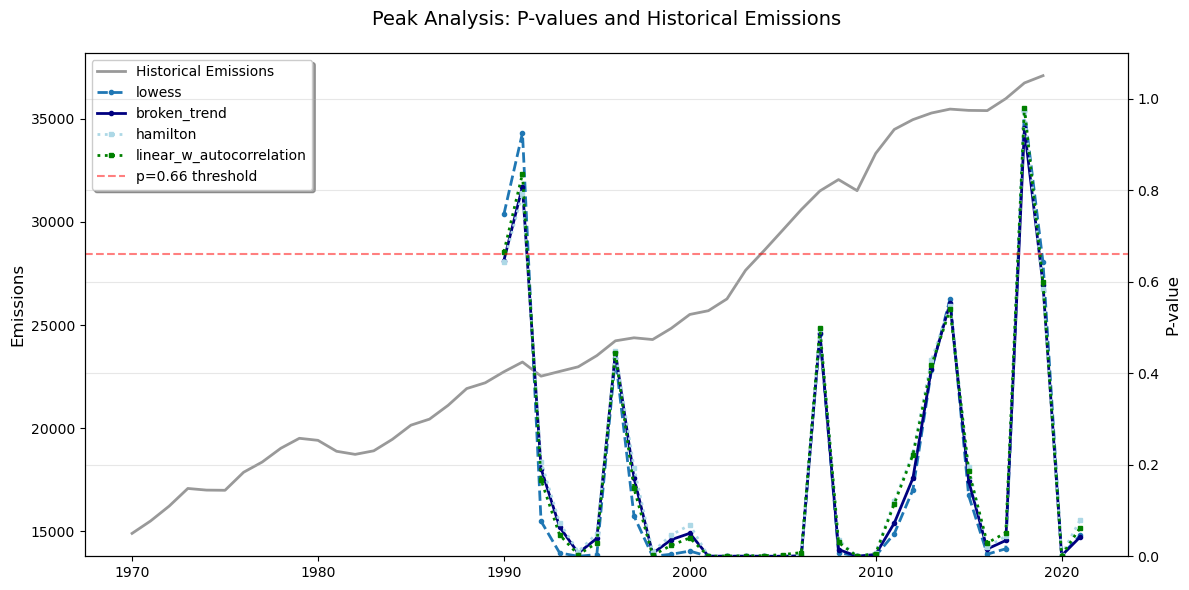

In [25]:
# Define your PDF results with styling
pdf_results = [
    {
        'data': pdf_3year['lowess'], 
        'label': 'lowess',
        'color': 'tab:blue',
        'marker': 'o',
        'linestyle': 'dashed'
    },
    {
        'data': pdf_3year['broken_trend'], 
        'label': 'broken_trend',
        'color': 'navy',
        'marker': 'o'
    },
    {
        'data': pdf_3year['hamilton'], 
        'label': 'hamilton',
        'color': 'lightblue',
        'marker': 's',
        'linestyle': 'dotted'
    },
    {
        'data': pdf_3year['linear_w_autocorrelation'], 
        'label': 'linear_w_autocorrelation',
        'color': 'green',
        'marker': 's',
        'linestyle': 'dotted'
    }
]

# Create the plot
fig, axes = plot_peak_analysis(
    EmissionsPeakTest().load_historical_data("gcb_hist_co2.csv","WLD").historical_data, 
    pdf_results,
    threshold=0.66,
    savepath="../figures/historical_method_comparison.png"
)
plt.show()

In [30]:
peak_tester = EmissionsPeakTest()
peak_tester.load_historical_data(data_source='gcb_hist_co2.csv', region = 'WLD', year_range = range(1970,2025))

Loaded historical data: 1970-2024
Data points: 55


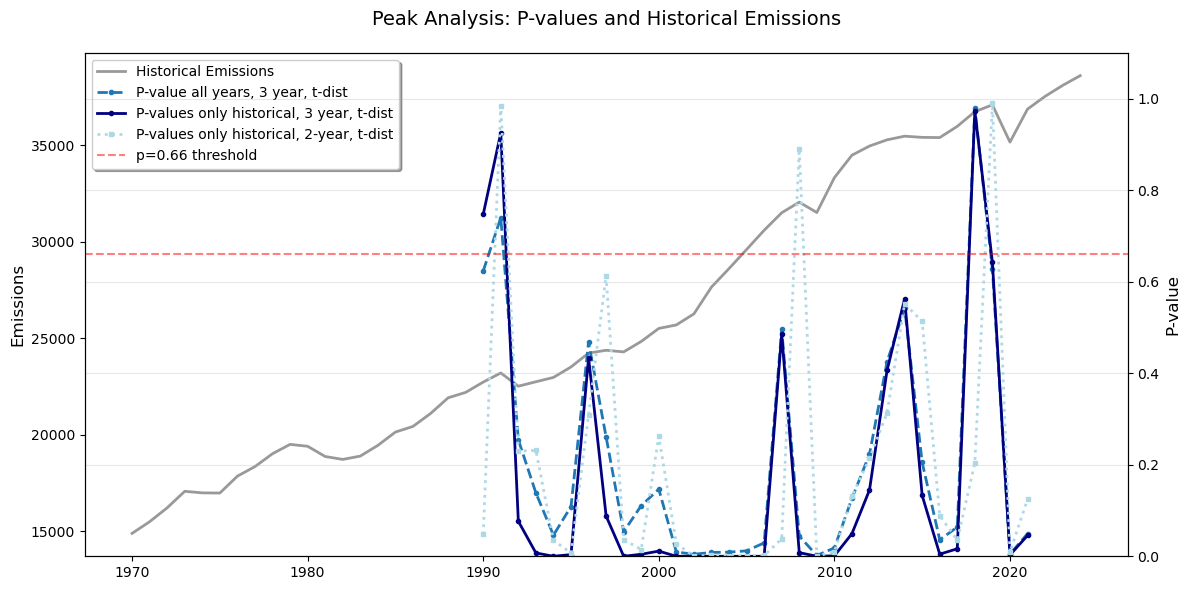

In [34]:
# Plot p-values
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot emissions on the first y-axis
ax1.set_ylabel('Emissions', color='black', fontsize=12)
ax1.plot(peak_tester.historical_data.year, peak_tester.historical_data.emissions, 
         color='gray', linewidth=2, label='Historical Emissions', alpha=0.8)
ax1.tick_params(axis='y', labelcolor='black')

# Create 2nd y axis for p-values
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('P-value', color='black', fontsize=12)

ax2.plot(pdf_3year_allyears['year'], 1-pdf_3year_allyears['p-value'], color=color, marker='o', linestyle = 'dashed',
         linewidth=2, label='P-value all years, 3 year, t-dist', markersize=3)
ax2.tick_params(axis='y', labelcolor='black')
ax2.grid(True, alpha=0.3)

ax2.plot(pdf_3year['lowess']['year'], 1-pdf_3year['lowess']['p-value'], color='navy', marker='o', 
         linewidth=2, label='P-values only historical, 3 year, t-dist', markersize=3)
# ax2.tick_params(axis='y', labelcolor=color)

ax2.plot(pdf_2year['year'], 1-pdf_2year['p-value'], color='lightblue', marker='s', linestyle = 'dotted',
         linewidth=2, label='P-values only historical, 2-year, t-dist', markersize=3)

# Add horizontal line at 1-p=0.66 for reference
ax2.axhline(y=0.66, color='red', linestyle='--', alpha=0.5, label='p=0.66 threshold')
# Set y-limits for p-values with some padding
max_p = max(pdf_3year_allyears['p-value'].max(), pdf_2year['p-value'].max())
ax2.set_ylim(0, max_p * 1.1)


# Add title and format
plt.title('Peak Analysis: P-values and Historical Emissions', fontsize=14, pad=20)
fig.tight_layout()

# Add legends - combining both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, 
           fancybox=True, shadow=True)

plt.savefig("../figures/pvalue_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

## Check difference between 2, 3 and 4 year tests around covid time

In [37]:
pdf_4yr = run_historical_peak_test(
    csv_file = 'gcb_hist_co2.csv',
    region = 'WLD',
    num_years_forward = 4,
    noise_type = 't-dist',
    noise_params = {'fraction': 0.3},
    bootstrap_method='ar_bootstrap',
    years_to_check = range(2017,2023),
    years_for_analysis = range(1970,2025))

Loaded historical data: 1970-2024
Data points: 55


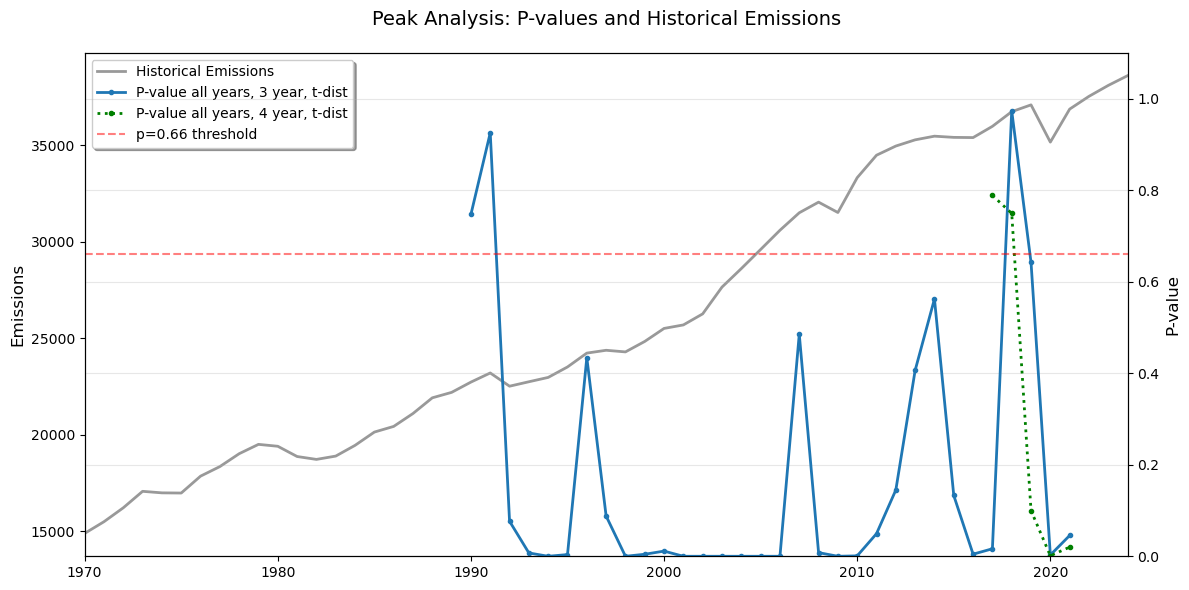

In [40]:
# Plot p-values
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot emissions on the first y-axis
ax1.set_ylabel('Emissions', color='black', fontsize=12)
ax1.plot(peak_tester.historical_data.year, peak_tester.historical_data.emissions, 
         color='gray', linewidth=2, label='Historical Emissions', alpha=0.8)
ax1.tick_params(axis='y', labelcolor='black')

# Create 2nd y axis for p-values
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('P-value', color='black', fontsize=12)

ax2.plot(pdf_3year['lowess']['year'], 1-pdf_3year['lowess']['p-value'], color=color, marker='o', linestyle = 'solid',
         linewidth=2, label='P-value all years, 3 year, t-dist', markersize=3)
ax2.tick_params(axis='y', labelcolor='black')
ax2.grid(True, alpha=0.3)

ax2.plot(pdf_4yr['year'], 1-pdf_4yr['p-value'], color='green', marker='o', linestyle = 'dotted',
         linewidth=2, label='P-value all years, 4 year, t-dist', markersize=3)
ax2.tick_params(axis='y', labelcolor='black')
ax2.grid(True, alpha=0.3)

# Add horizontal line at 1-p=0.66 for reference
ax2.axhline(y=0.66, color='red', linestyle='--', alpha=0.5, label='p=0.66 threshold')
# Set y-limits for p-values with some padding
max_p = max(pdf_3year['lowess']['p-value'].max(), pdf_3year['lowess']['p-value'].max())
ax2.set_ylim(0, max_p * 1.1)
ax2.set_xlim(1970, 2024)


# Add title and format
plt.title('Peak Analysis: P-values and Historical Emissions', fontsize=14, pad=20)
fig.tight_layout()

# Add legends - combining both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, 
           fancybox=True, shadow=True)

Loaded historical data: 1971-2023
Data points: 53


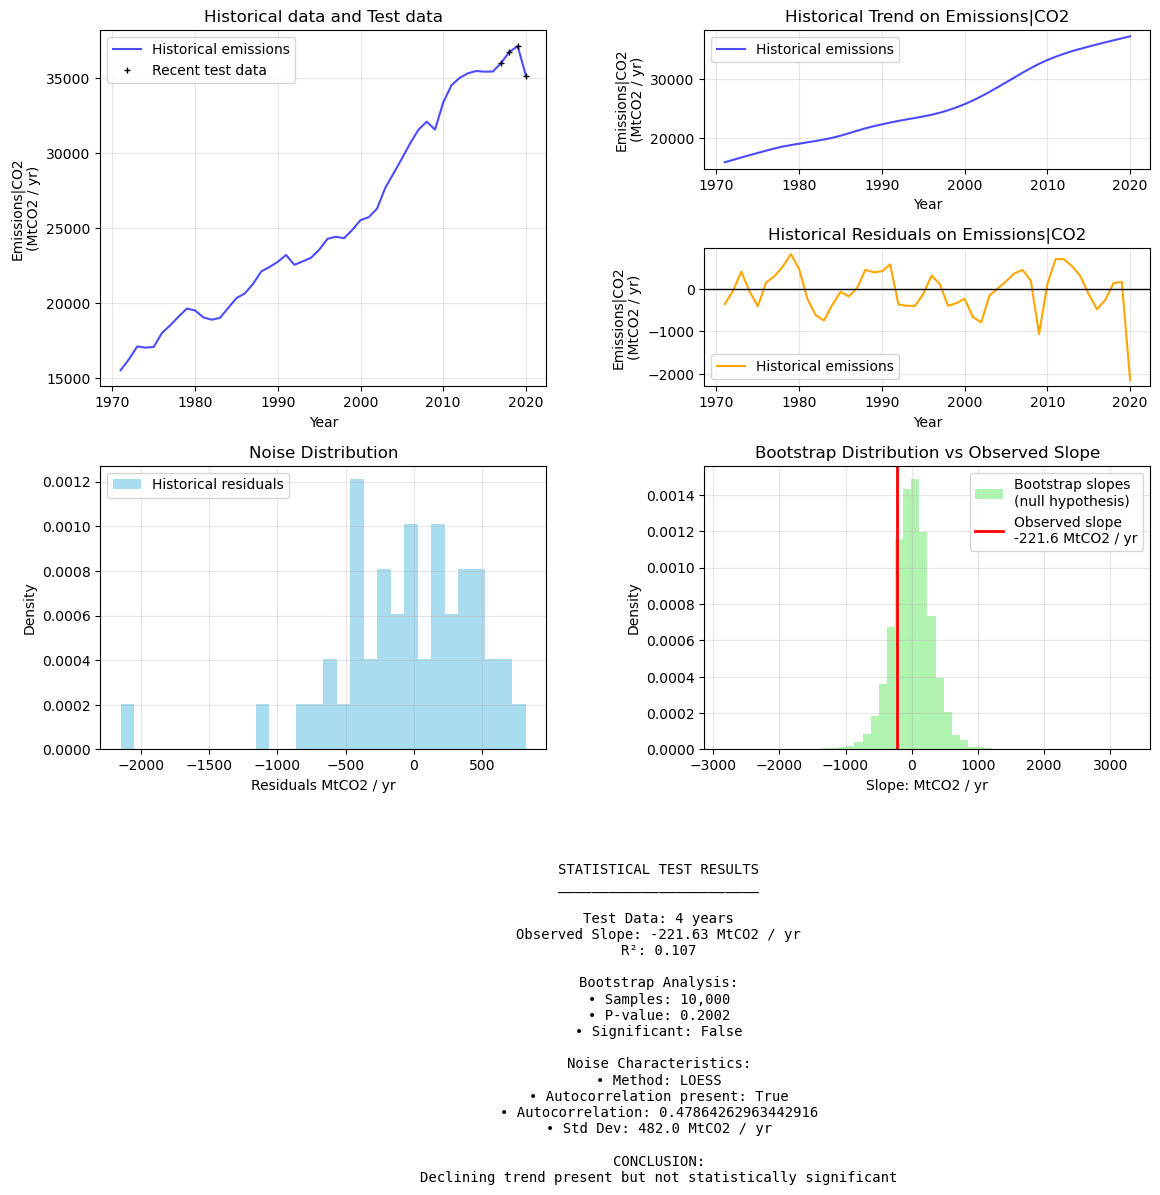

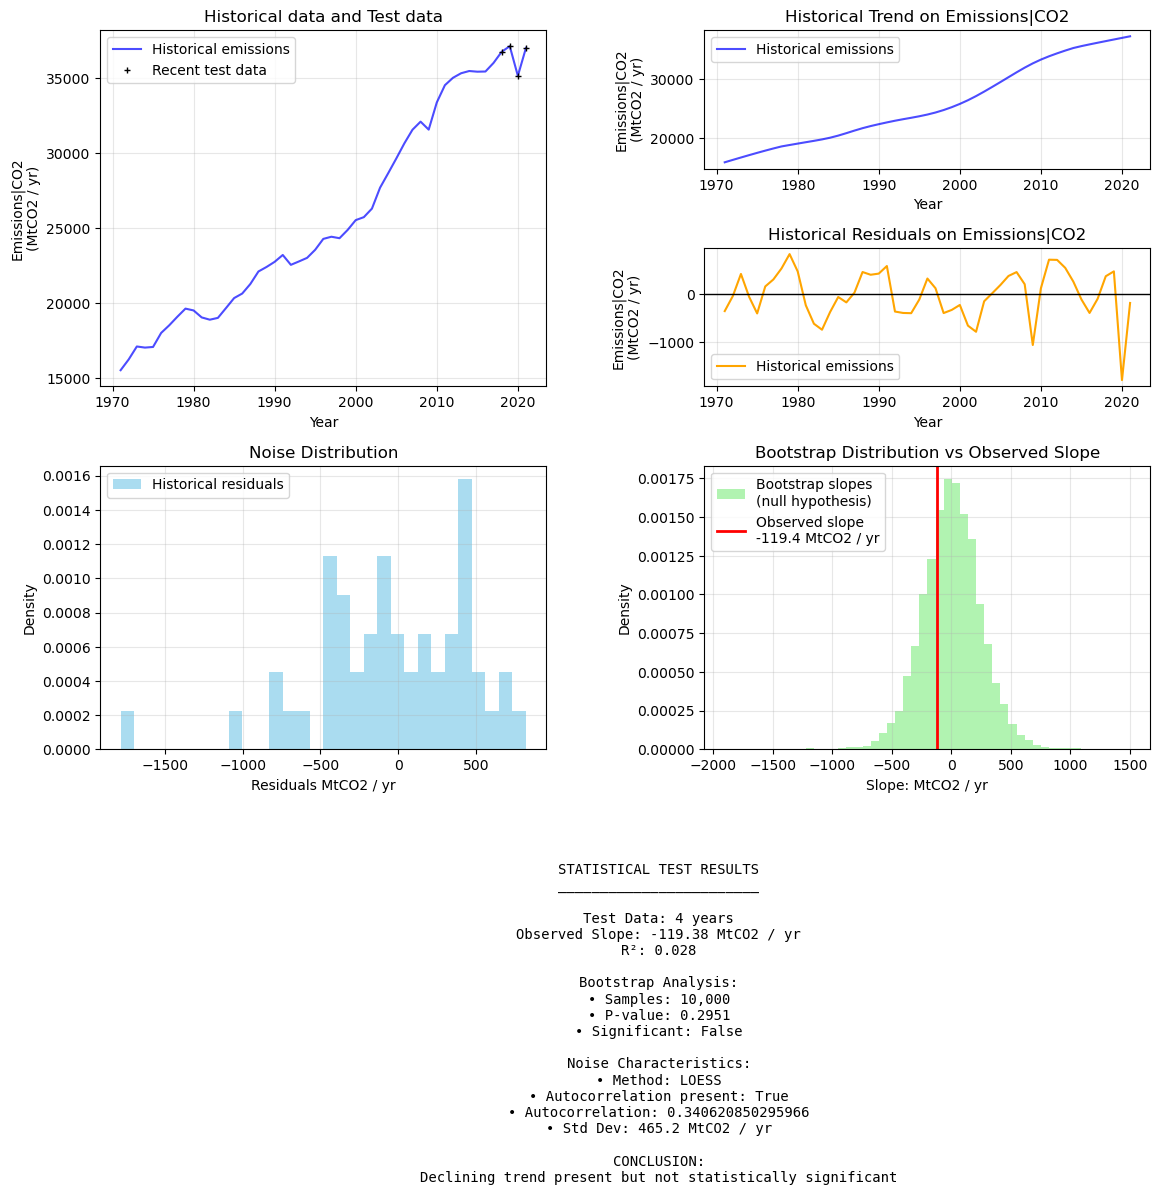

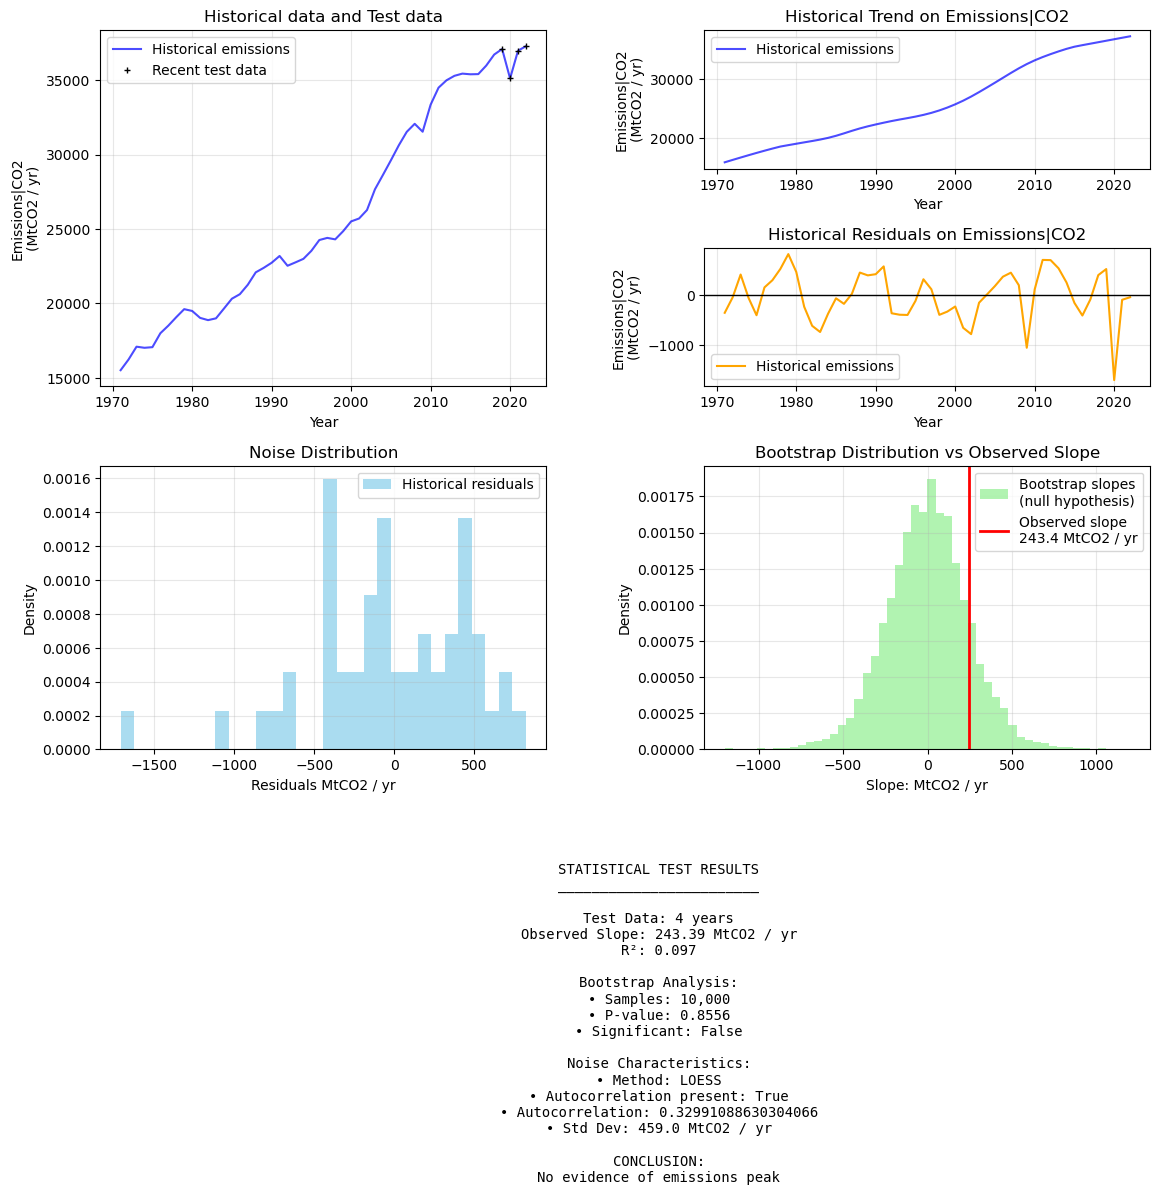

In [ ]:
# check peaks around covid

#TODO: Neil -> are these cells still needed? I think perhaps not?

covid_test = EmissionsPeakTest()
covid_test.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,2024))
hist_data = covid_test.historical_data
p_list = []
years_to_check = [2017, 2018, 2019]
for year in years_to_check:
    years_to_test = [year, year+1, year+2, year+3]
    em_0 = hist_data.loc[hist_data.year==year,'emissions'].squeeze()
    em_1 = hist_data.loc[hist_data.year==year+1,'emissions'].squeeze()
    em_2 = hist_data.loc[hist_data.year==year+2,'emissions'].squeeze()
    em_3 = hist_data.loc[hist_data.year==year+3,'emissions'].squeeze()

    
        # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
    with HiddenPrints():
        covid_test.historical_data = hist_data.query(f'year <= {year+3}').copy()
        covid_test.characterize_noise(method='loess', noise_type = 't-dist') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
        covid_test.create_noise_generator()
        covid_test.set_test_data([
                (year, em_0),
                (year+1, em_1), 
                (year+2, em_2),
                (year+3, em_3)
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        p_list.append(covid_test.bootstrap_results['p_value_one_tail'])
        covid_test.plot_analysis()
pdfcovid_4yr = pd.DataFrame({
    'year': years_to_check,
    'p-value': p_list
})

Loaded historical data: 1971-2023
Data points: 53


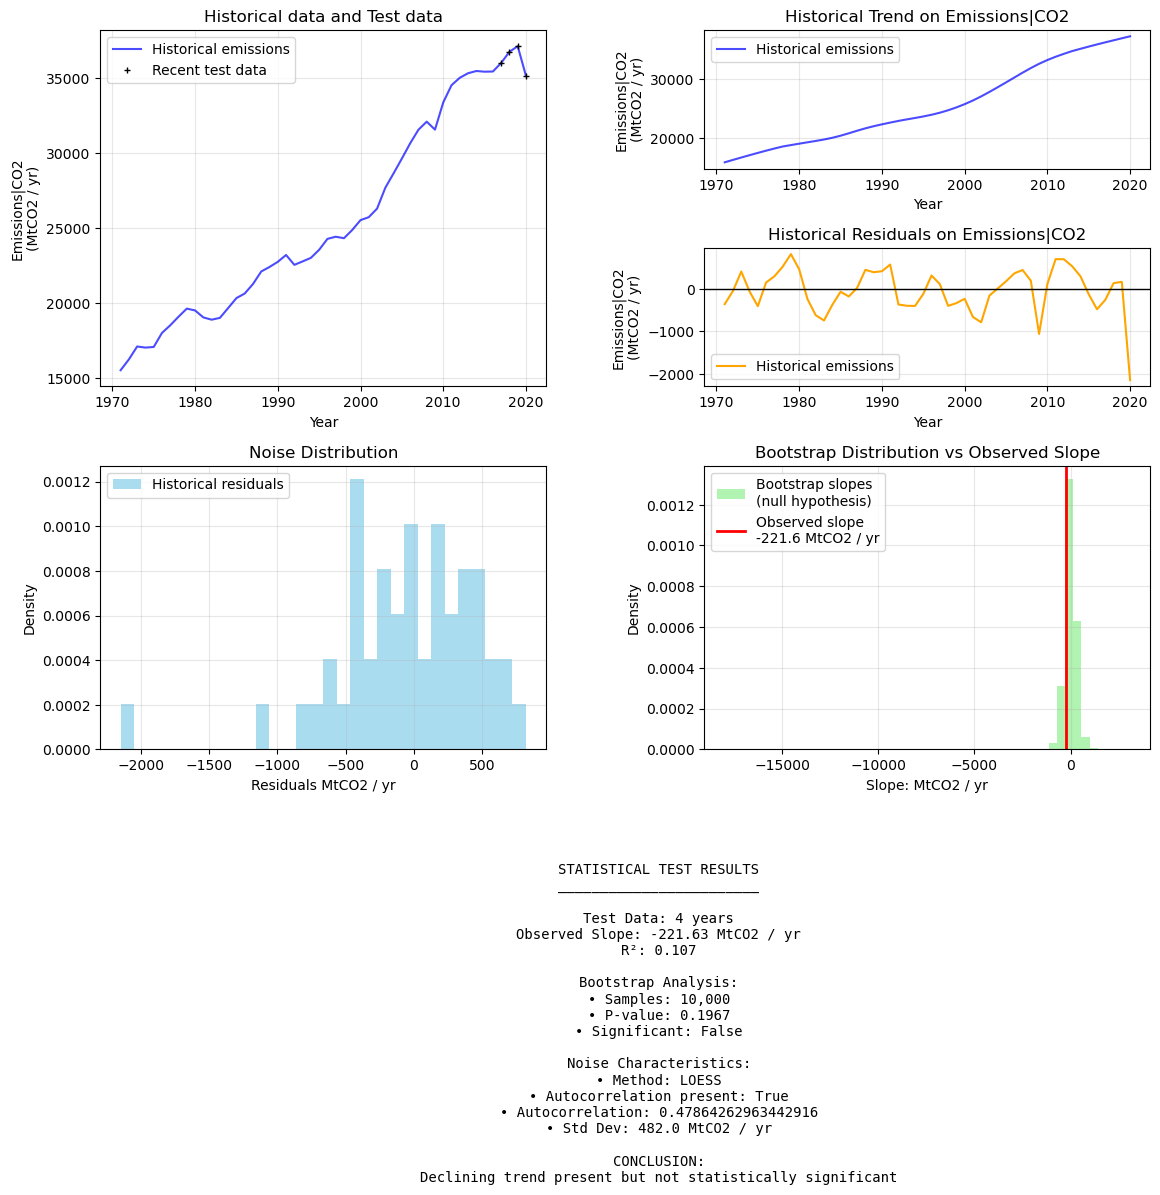

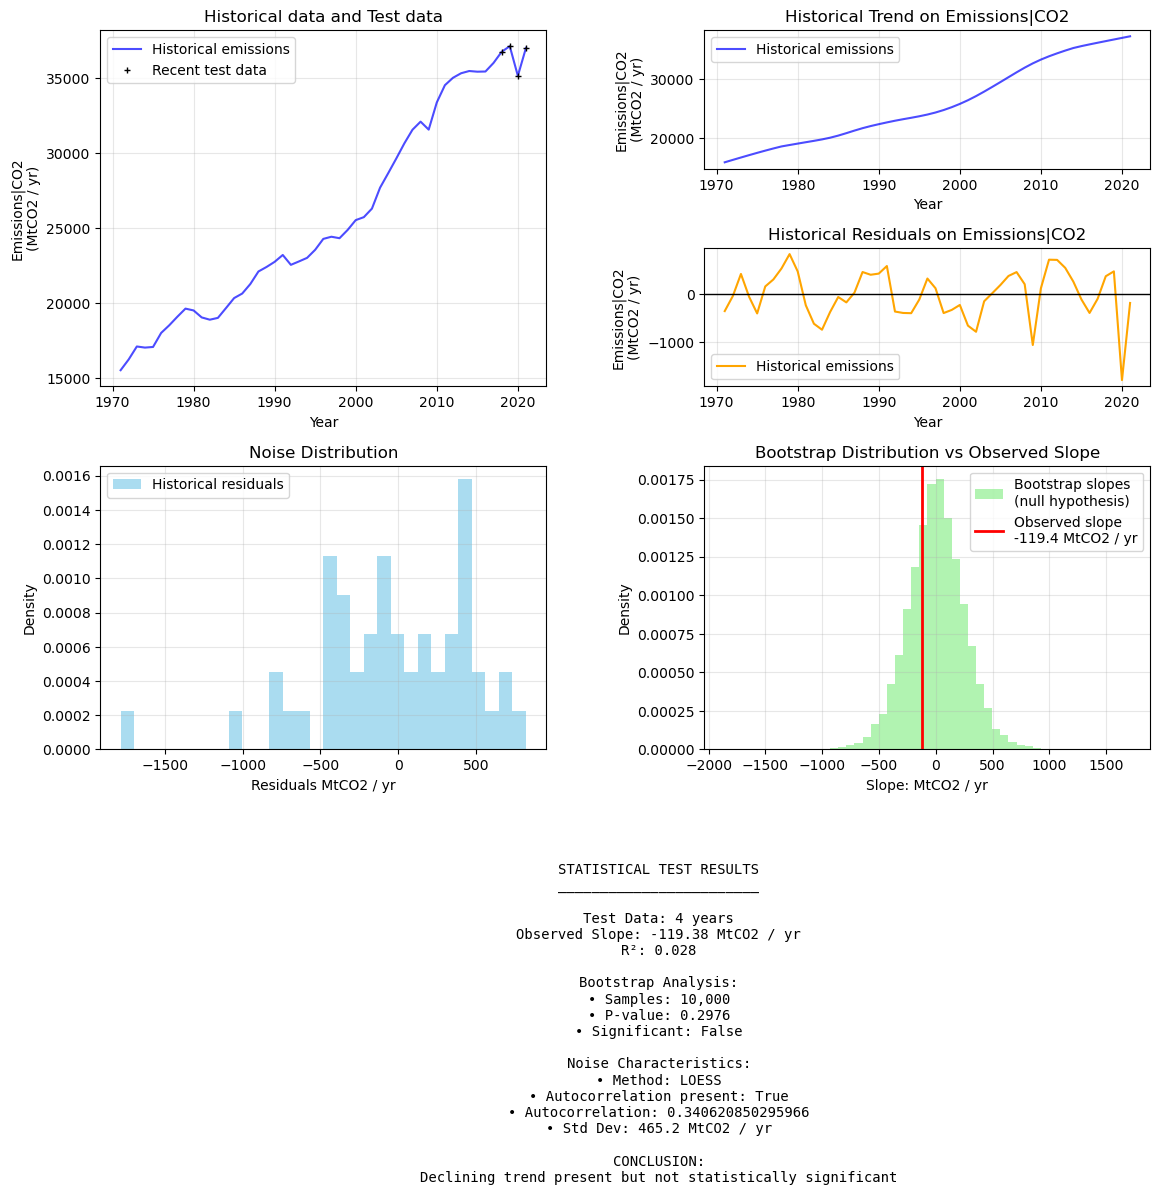

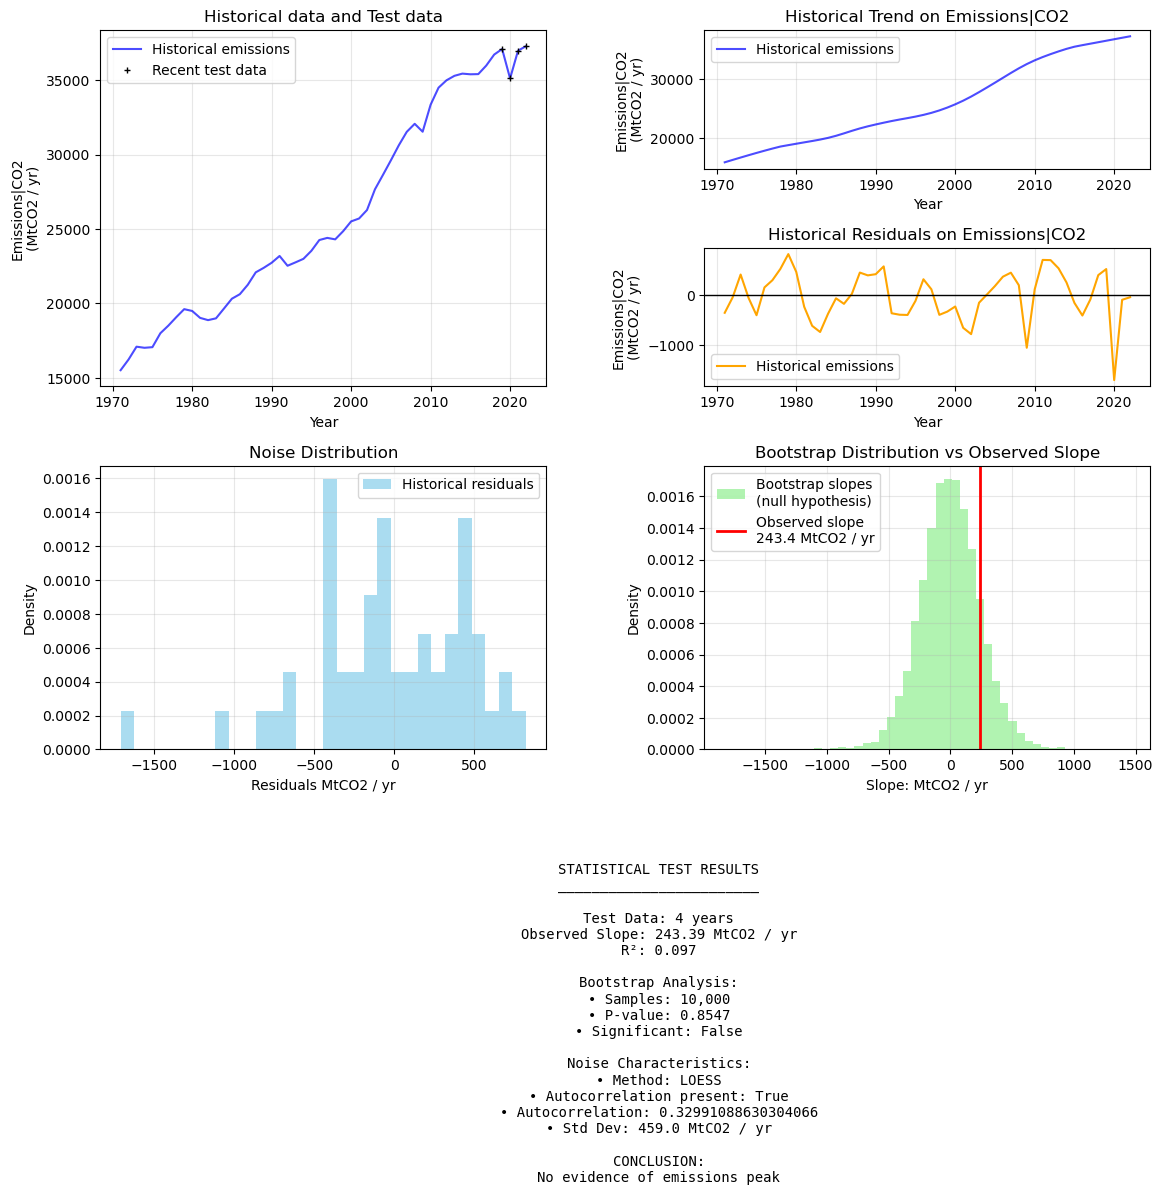

In [ ]:
# check peaks around covid - with updated script

#TODO: Neil -> are these cells still needed? I think perhaps not?

covid_test = EmissionsPeakTest()
covid_test.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,2024))
hist_data = covid_test.historical_data
p_list = []
years_to_check = [2017, 2018, 2019]
for year in years_to_check:
    years_to_test = [year, year+1, year+2, year+3]
    em_0 = hist_data.loc[hist_data.year==year,'emissions'].squeeze()
    em_1 = hist_data.loc[hist_data.year==year+1,'emissions'].squeeze()
    em_2 = hist_data.loc[hist_data.year==year+2,'emissions'].squeeze()
    em_3 = hist_data.loc[hist_data.year==year+3,'emissions'].squeeze()

    
        # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
    with HiddenPrints():
        covid_test.historical_data = hist_data.query(f'year <= {year+3}').copy()
        covid_test.characterize_noise(method='loess', noise_type = 't-dist') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
        covid_test.create_noise_generator()
        covid_test.set_test_data([
                (year, em_0),
                (year+1, em_1), 
                (year+2, em_2),
                (year+3, em_3)
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        p_list.append(covid_test.bootstrap_results['p_value_one_tail'])
        covid_test.plot_analysis()
pdfcovid_4yr = pd.DataFrame({
    'year': years_to_check,
    'p-value': p_list
})

Loaded historical data: 1971-2023
Data points: 53


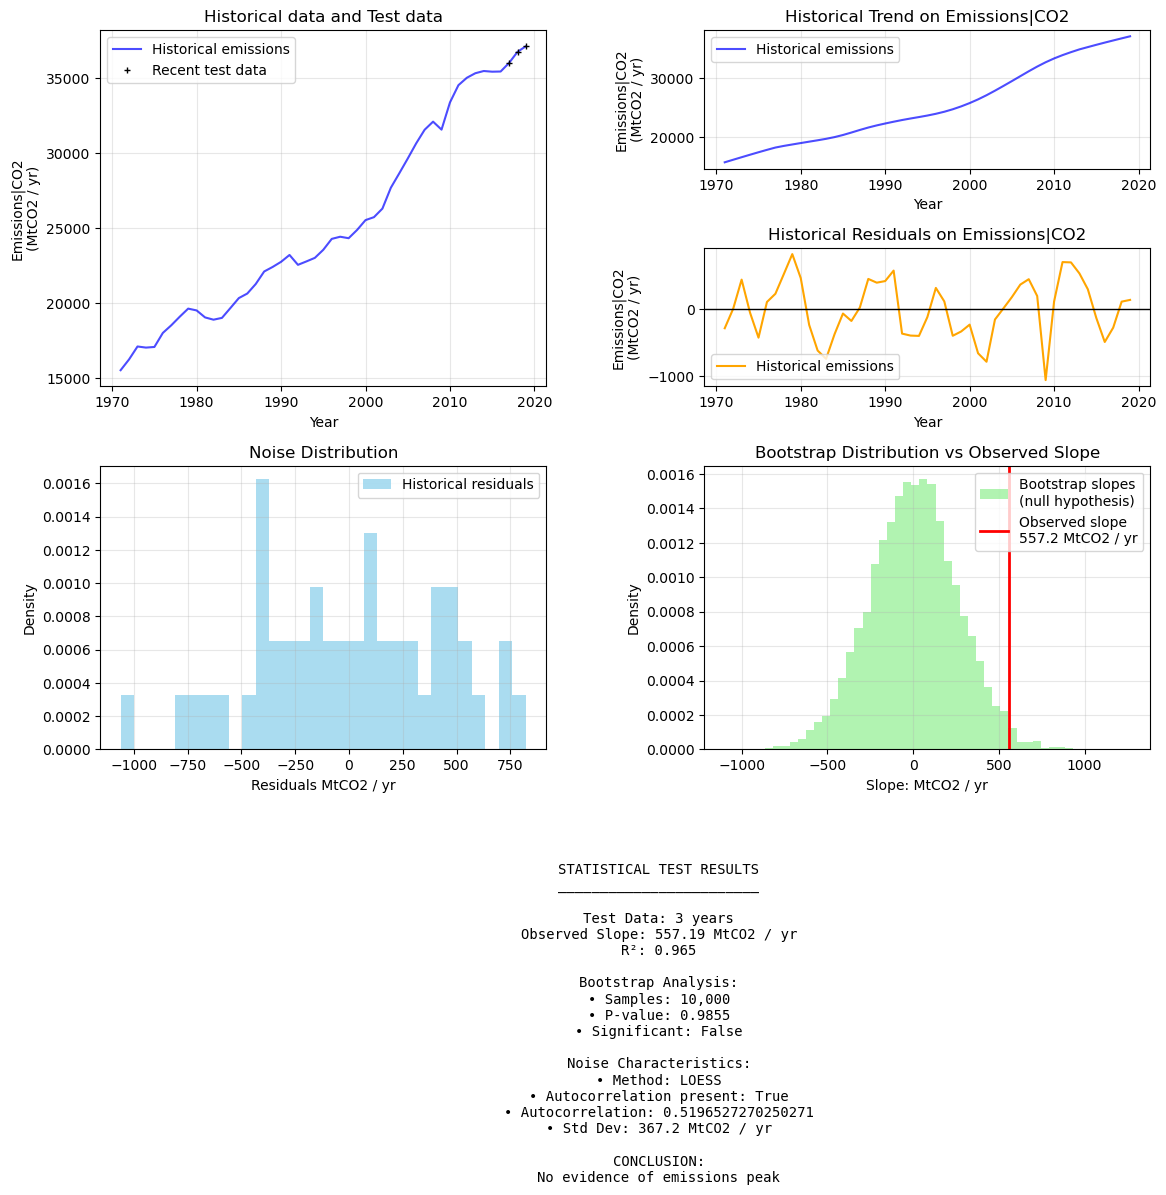

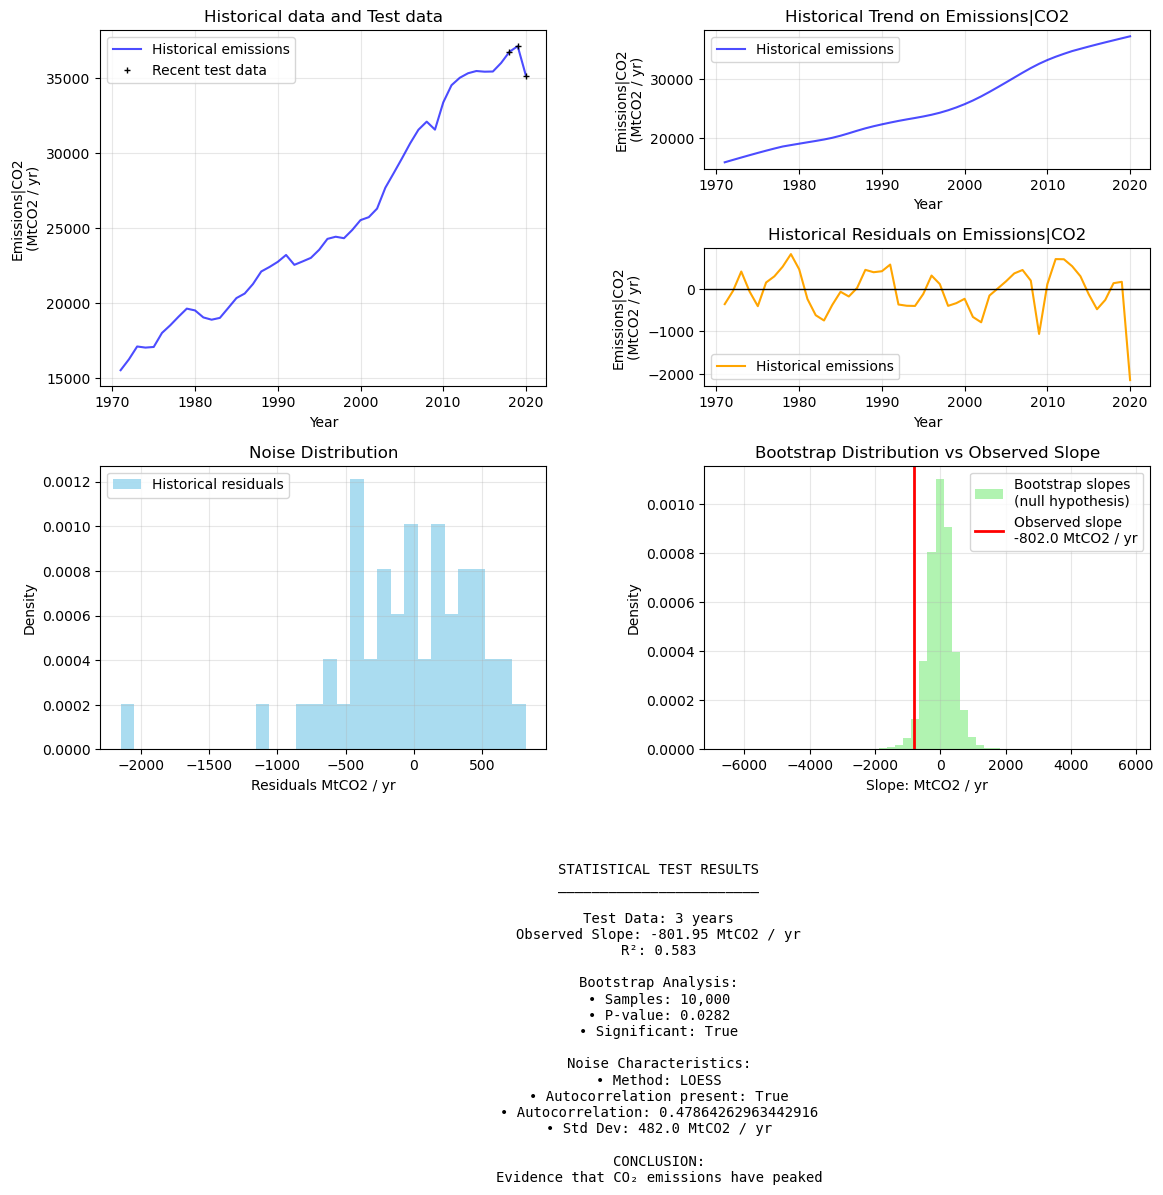

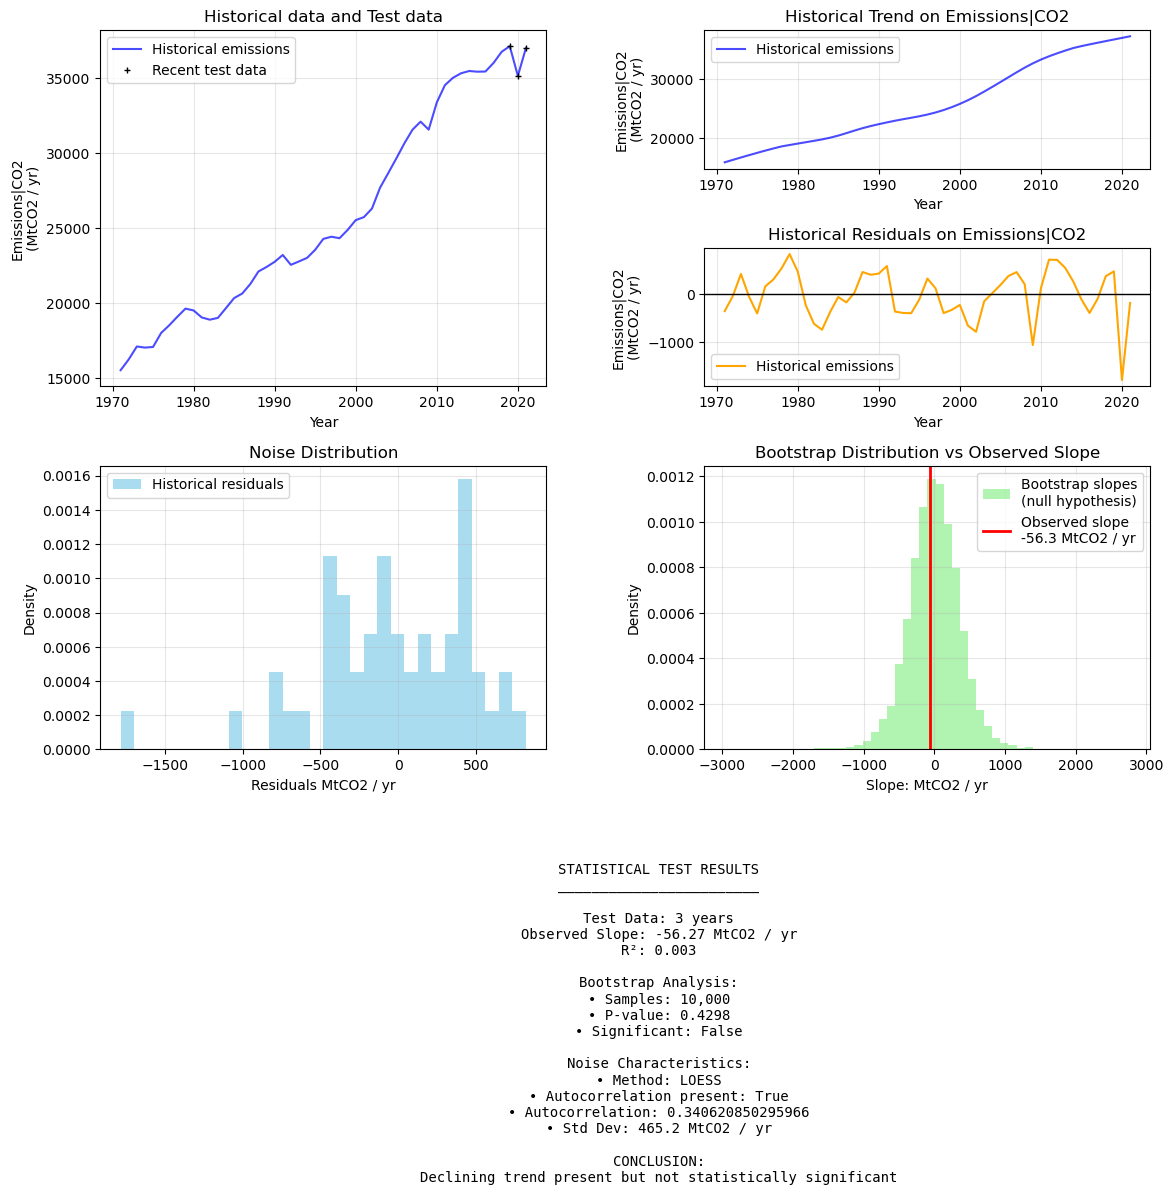

In [ ]:
# check peaks around covid

#TODO: Neil -> are these cells still needed? I think perhaps not?

covid_test = EmissionsPeakTest()
covid_test.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,2024))
hist_data = covid_test.historical_data
p_list = []
years_to_check = [2017, 2018, 2019]
for year in years_to_check:
    years_to_test = [year, year+1, year+2]
    em_0 = hist_data.loc[hist_data.year==year,'emissions'].squeeze()
    em_1 = hist_data.loc[hist_data.year==year+1,'emissions'].squeeze()
    em_2 = hist_data.loc[hist_data.year==year+2,'emissions'].squeeze()

    
        # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
    with HiddenPrints():
        covid_test.historical_data = hist_data.query(f'year <= {year+2}').copy()
        covid_test.characterize_noise(method='loess', noise_type = 't-dist') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
        covid_test.create_noise_generator()
        covid_test.set_test_data([
                (year, em_0),
                (year+1, em_1), 
                (year+2, em_2),
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        p_list.append(covid_test.bootstrap_results['p_value_one_tail'])
        covid_test.plot_analysis()
pdfcovid_3yr = pd.DataFrame({
    'year': years_to_check,
    'p-value': p_list
})

Loaded historical data: 1971-2023
Data points: 53


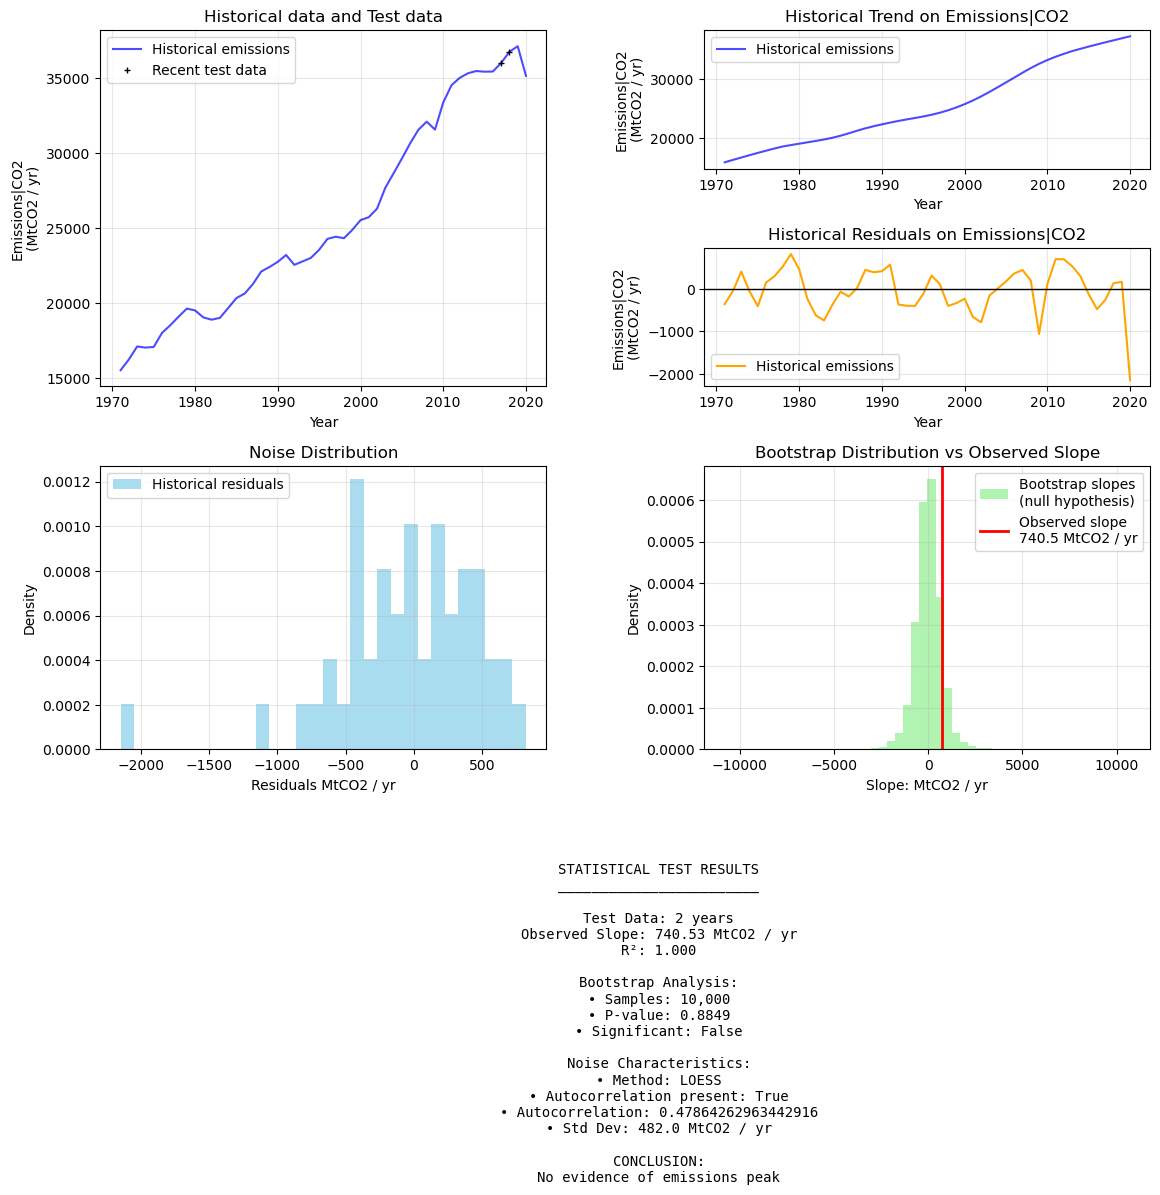

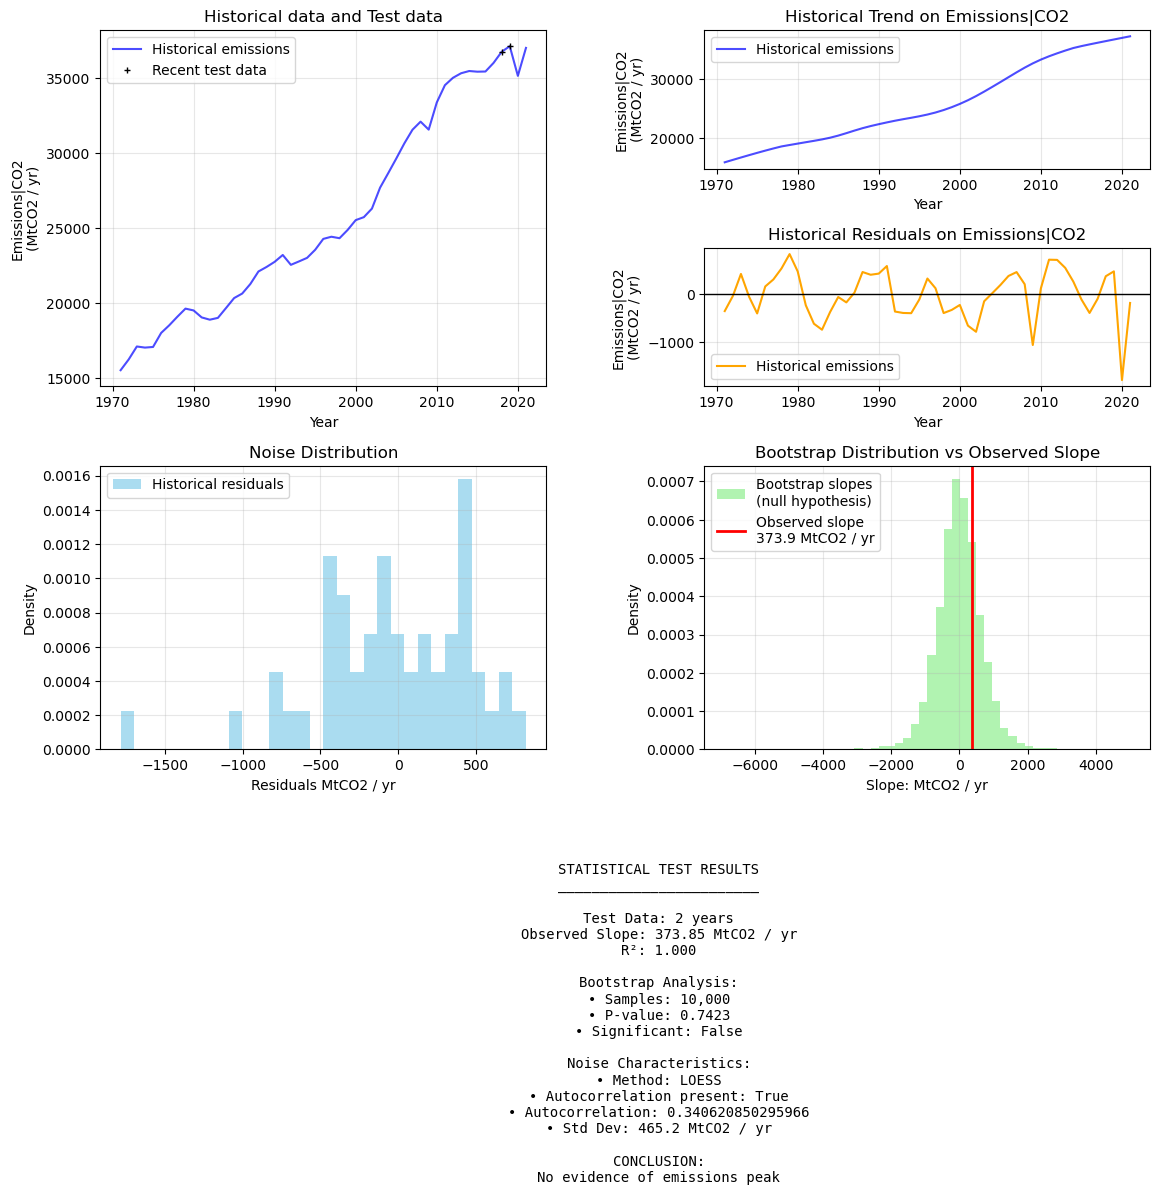

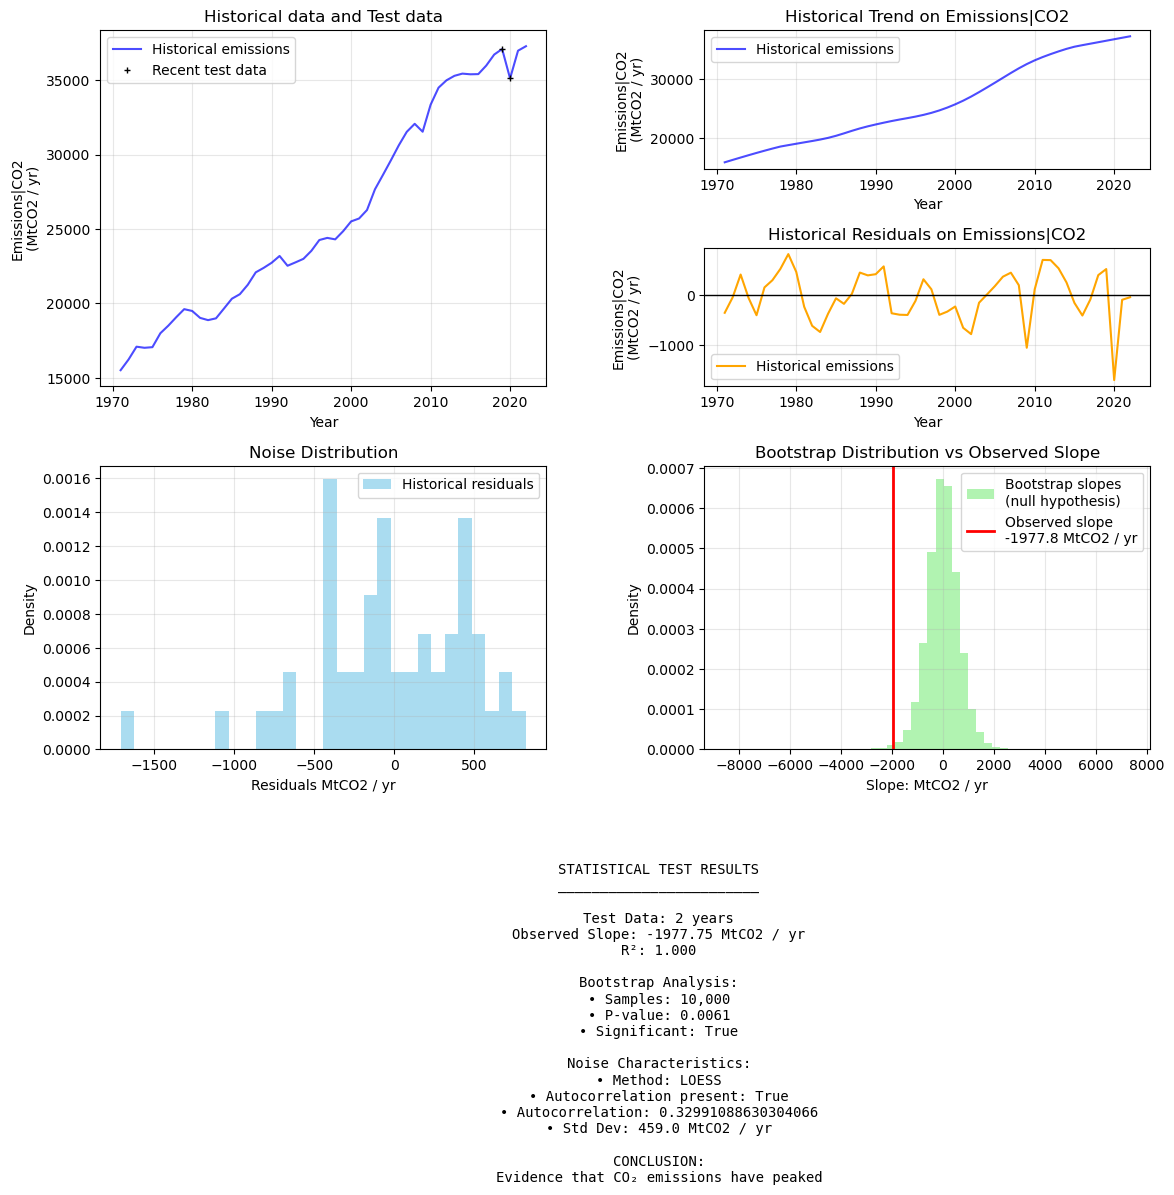

In [ ]:
# check peaks around covid - 2 year

#TODO: Neil -> are these cells still needed? I think perhaps not?
covid_test = EmissionsPeakTest()
covid_test.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,2024))
hist_data = covid_test.historical_data
p_list = []
years_to_check = [2017, 2018, 2019]
for year in years_to_check:
    years_to_test = [year, year+1,]
    em_0 = hist_data.loc[hist_data.year==year,'emissions'].squeeze()
    em_1 = hist_data.loc[hist_data.year==year+1,'emissions'].squeeze()


    
        # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
    with HiddenPrints():
        covid_test.historical_data = hist_data.query(f'year <= {year+3}').copy()
        covid_test.characterize_noise(method='loess', noise_type = 't-dist') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
        covid_test.create_noise_generator()
        covid_test.set_test_data([
                (year, em_0),
                (year+1, em_1), 
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        p_list.append(covid_test.bootstrap_results['p_value_one_tail'])
        covid_test.plot_analysis()
pdfcovid_2yr = pd.DataFrame({
    'year': years_to_check,
    'p-value': p_list
})

Loaded historical data: 1971-2023
Data points: 53


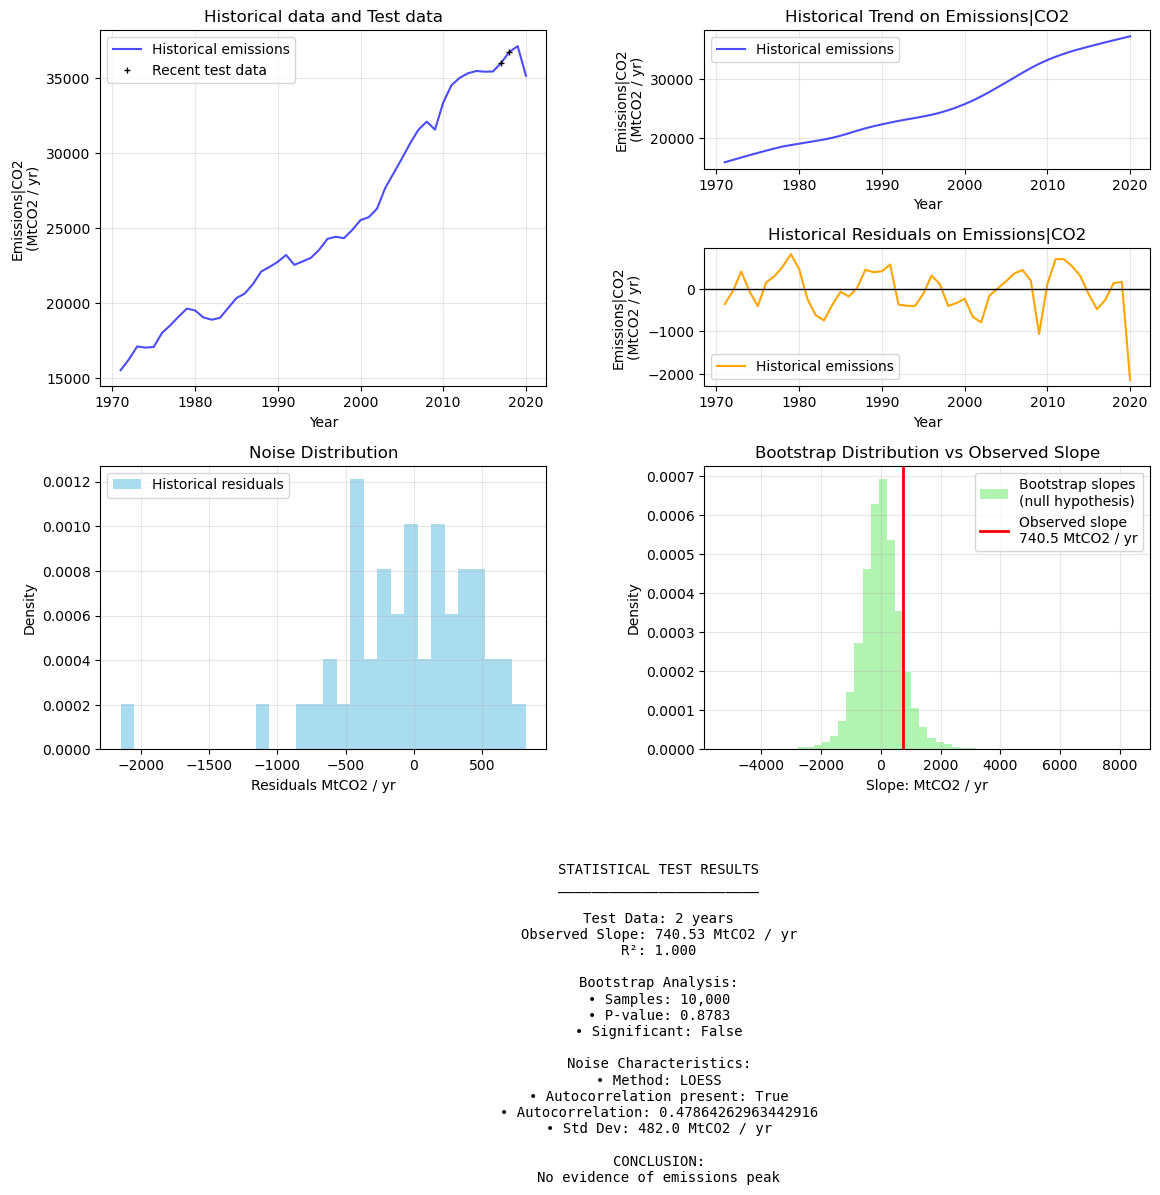

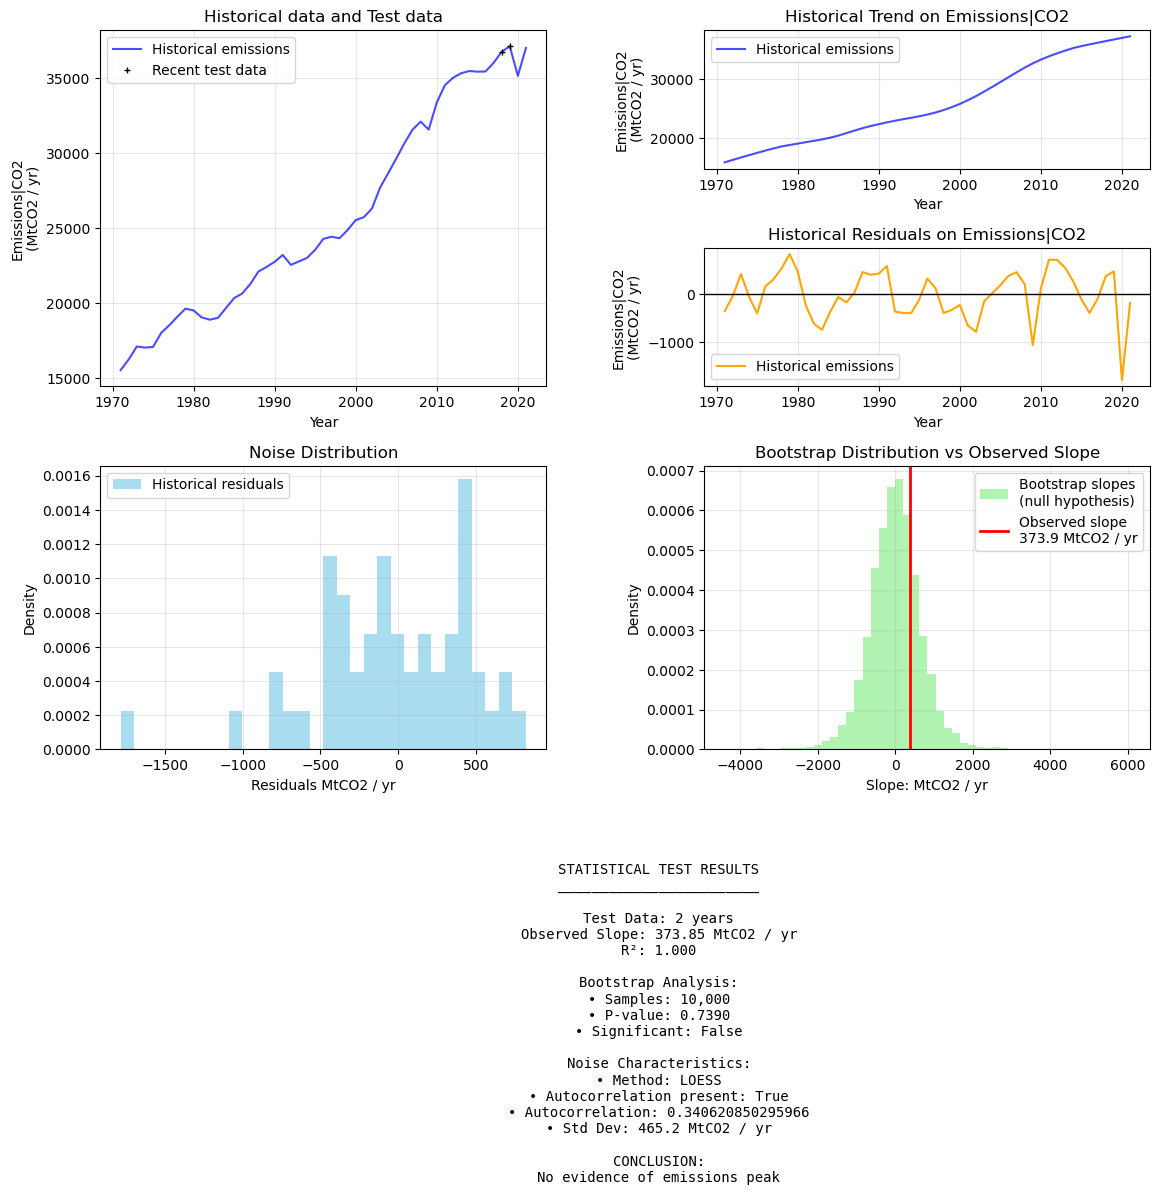

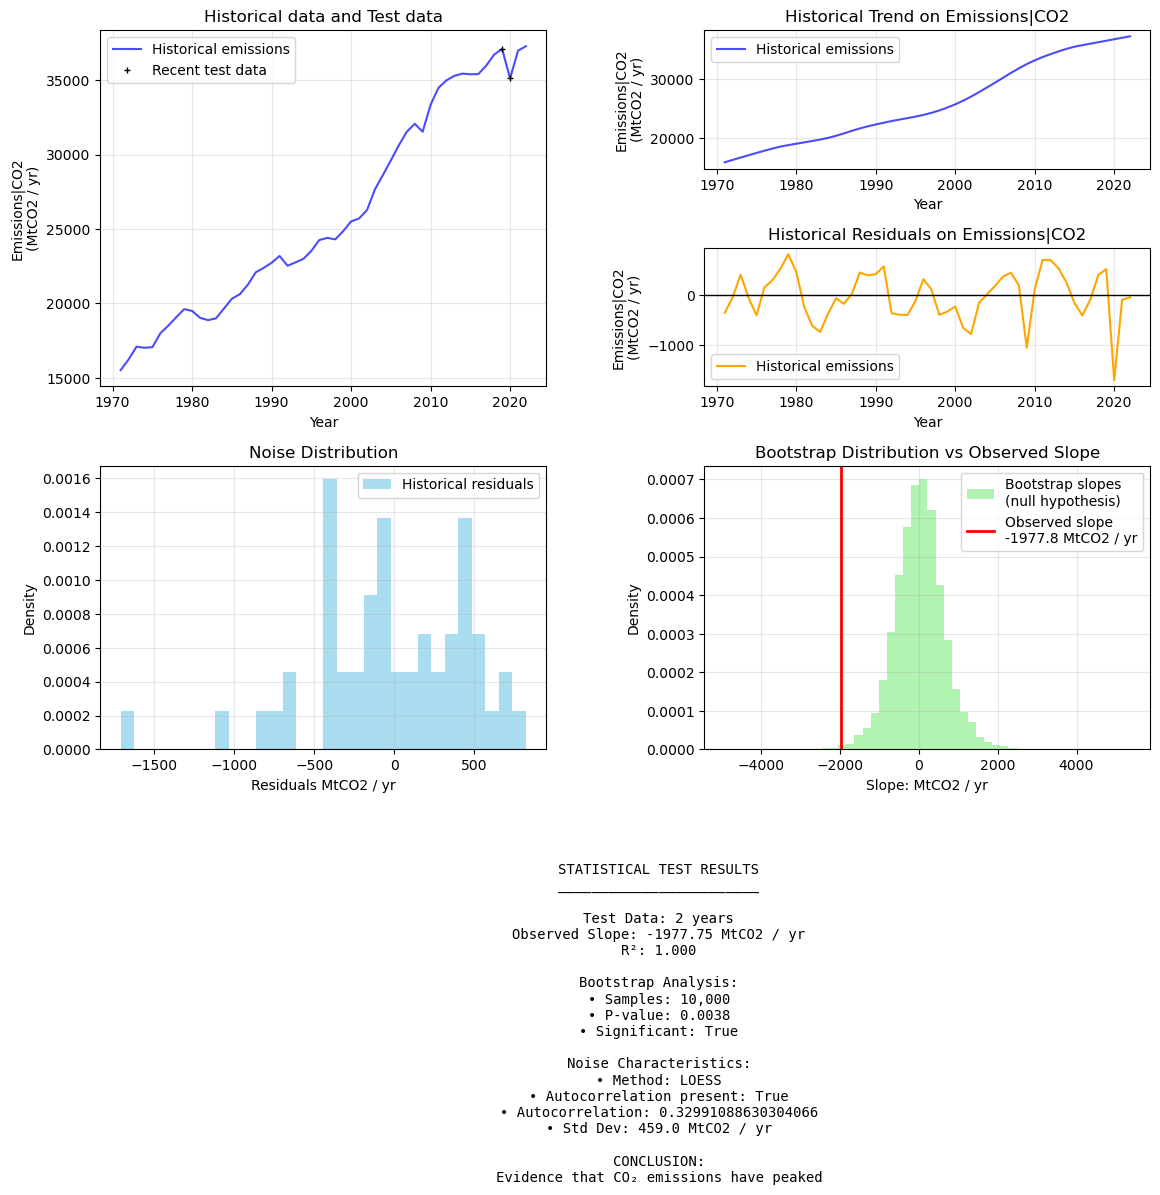

In [ ]:
# check peaks around covid - 2 year - with updated script

#TODO: Neil -> are these cells still needed? I think perhaps not?
covid_test = EmissionsPeakTest()
covid_test.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,2024))
hist_data = covid_test.historical_data
p_list = []
years_to_check = [2017, 2018, 2019]
for year in years_to_check:
    years_to_test = [year, year+1,]
    em_0 = hist_data.loc[hist_data.year==year,'emissions'].squeeze()
    em_1 = hist_data.loc[hist_data.year==year+1,'emissions'].squeeze()


    
        # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
    with HiddenPrints():
        covid_test.historical_data = hist_data.query(f'year <= {year+3}').copy()
        covid_test.characterize_noise(method='loess', noise_type = 't-dist') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
        covid_test.create_noise_generator()
        covid_test.set_test_data([
                (year, em_0),
                (year+1, em_1), 
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        p_list.append(covid_test.bootstrap_results['p_value_one_tail'])
        covid_test.plot_analysis()
pdfcovid_2yr = pd.DataFrame({
    'year': years_to_check,
    'p-value': p_list
})

In [268]:
from sklearn.linear_model import LinearRegression

em_0 = hist_data.loc[hist_data.year==2017,'emissions'].squeeze()
em_1 = hist_data.loc[hist_data.year==2018,'emissions'].squeeze()
em_2 = hist_data.loc[hist_data.year==2019,'emissions'].squeeze()
em_3 = hist_data.loc[hist_data.year==2020,'emissions'].squeeze()


x = [2017, 2018, 2019, 2020]
        # y = self.test_data["emissions"].values
y = [em_0, em_1, em_2, em_3]

# Convert x to a 2D array (scikit-learn expects 2D inputs for features)
X = np.array(x).reshape(-1, 1)
y = np.array(y)

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Get the coefficients
slope = model.coef_[0]
intercept = model.intercept_

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")


Slope: -221.62639799999812
Intercept: 483590.6664679962


In [238]:
pdfcovid2 = run_historical_peak_test(
    csv_file = 'gcb_hist_co2.csv',
    num_years_forward = 4,
    noise_type = 't-dist',
    noise_params = {'fraction': 0.3},
    bootstrap_method='ar_bootstrap',
    years_to_check = [2017, 2020],
    years_for_analysis = [1970, 2024])


Loaded historical data: 1970-2023
Data points: 54


In [242]:
pdfcovid2

year  p-value  num_years_forward noise_type                test_years  \
0  2017   0.1700                  4     t-dist  [2017, 2018, 2019, 2020]   
1  2018   0.2964                  4     t-dist  [2018, 2019, 2020, 2021]   
2  2019   0.8425                  4     t-dist  [2019, 2020, 2021, 2022]   

                                    emissions_tested  
0  [35989.89788, 36730.42656, 37104.27786, 35126....  
1  [36730.42656, 37104.27786, 35126.52612, 36991....  
2  [37104.27786, 35126.52612, 36991.73628, 37293....

In [ ]:
# Why is the 2 year not giving a peak in 2019?

## Carbon intensity

In [41]:
fossil_co2 = pd.read_csv('../data/processed/gcb_hist_co2.csv')
gdp = pd.read_csv('../data/processed/wdi_gdp.csv')
ci = pd.read_csv('../data/processed/carbon_intensity_gdp.csv')

co2_wld = fossil_co2.loc[fossil_co2['region']=='WLD']
gdp_wld = gdp.loc[gdp['region']=='WLD']
ci_wld = ci.loc[ci['region']=='WLD']


In [46]:
years = np.arange(1990, 2024, 1)
gdp_growth_rate = []
for year in years:
    gdp_growth_rate.append([year, (gdp.loc[gdp['region']=='WLD', str(year)].squeeze() / gdp.loc[gdp['region']=='WLD', str(year-1)].squeeze())-1])

gdp_growth = pd.DataFrame(gdp_growth_rate, columns = ['year', 'growth'])

In [55]:

years_to_check = range(1990,2022)
years_for_analysis = range(1970,2025)
all_results = []

for growth in [0.02, 0.03]:
    for frac in [0.3]: #0.15, 0.175, 0.2, 0.225, 0.25,
        results = run_historical_peak_test(csv_file='carbon_intensity_gdp.csv', 
                                              region = 'WLD', num_years_forward=3, noise_type='t-dist',
                                              years_to_check = years_to_check, years_for_analysis = years_for_analysis,
                                              null_hypothesis_growth = growth, noise_params = {'fraction': frac})
        all_results.append(results)

flat_results = pd.concat(all_results, ignore_index=True)
flat_results.to_csv('results/carbon_intensity_historical_testing.csv')



Loaded historical data: 1970-2024
Data points: 55


KeyboardInterrupt: 

Loaded historical data: 1970-2024
Data points: 55


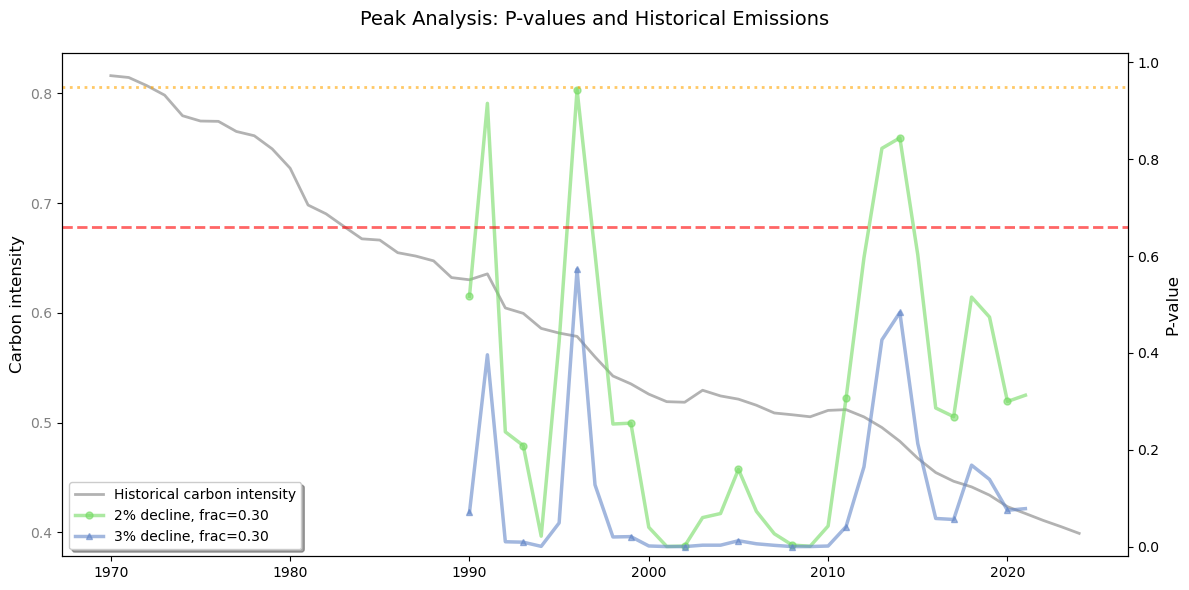

In [58]:
# Plot p-values (carbon intensity)
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

df = flat_results

ci_tester = EmissionsPeakTest()
ci_tester.load_historical_data('carbon_intensity_gdp.csv', region = 'WLD', year_range = range(1970,2025))
hist_data = ci_tester.historical_data

# Plot emissions on the first y-axis
ax1.set_ylabel('Carbon intensity', color='black', fontsize=12)
ax1.plot(ci_tester.historical_data.year, ci_tester.historical_data.emissions, 
         color='gray', linewidth=2, label='Historical carbon intensity', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='grey')

# Create 2nd y axis for p-values
ax2 = ax1.twinx()
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('P-value', fontsize=12)

# Define color palettes for each null hypothesis
# Greens for null_hypothesis = 0.02 (2% annual decline)
green_palette = {
    0.150: '#1b4f0a',   # Darkest green
    0.175: '#2d6b1c',
    0.200: '#3f872e',
    0.225: '#51a340',
    0.250: '#63bf52',
    0.300: '#75db64'    # Lightest green
}

# Blues for null_hypothesis = 0.03 (3% annual decline) 
blue_palette = {
    0.150: '#0a1e3c',   # Darkest blue
    0.175: '#1c3358',
    0.200: '#2e4874',
    0.225: '#405d90',
    0.250: '#5272ac',
    0.300: '#6487c8'    # Lightest blue
}

# Use all fractions for comprehensive view, or subset for clarity
fractions_to_show = [0.1, 0.15, 0.2, 0.3]  # Simplified view
# fractions_to_show = sorted(df['fraction'].unique())  # All fractions

# Store plotted lines for legend management
plotted_lines = []

# Plot each null hypothesis and fraction combination
for null_hyp in sorted(df['null_hypothesis'].unique()):
    # Select appropriate color palette
    colors = green_palette if null_hyp == 0.02 else blue_palette
    
    for fraction in fractions_to_show:
        # Filter data
        mask = (df['null_hypothesis'] == null_hyp) & (df['parameters'] == {'fraction': fraction})
        data_subset = df[mask].sort_values('year')
        
        if len(data_subset) > 0:
            # Get color for this fraction
            color = colors.get(fraction, 'gray')
            
            # Style variations
            marker = 'o' if null_hyp == 0.02 else '^'
            linewidth = 2.5 if fraction in [0.15, 0.30] else 1.8
            alpha = 0.8 if fraction in [0.15, 0.20] else 0.6
            markersize = 5 if fraction in [0.15, 0.30] else 3
            
            # Plot the line
            label = f'{int(null_hyp*100)}% decline, frac={fraction:.2f}'
            line, = ax2.plot(data_subset['year'], 1 - data_subset['p-value'], 
                           color=color, marker=marker,
                           linewidth=linewidth, alpha=alpha,
                           markersize=markersize, 
                           markevery=3,  # Show marker every 3rd point
                           label=label)
            plotted_lines.append((line, null_hyp, fraction))




# Add horizontal line at 1-p=0.66 for reference
# ax2.axhline(y=0.66, color='red', linestyle='--', alpha=0.5, label='p=0.66 threshold')

# Add reference lines
ref_line1 = ax2.axhline(y=0.66, color='red', linestyle='--', alpha=0.6, linewidth=2)
ref_line2 = ax2.axhline(y=0.95, color='orange', linestyle=':', alpha=0.6, linewidth=2)

# Highlight regions of significance
# ax2.axhspan(0.95, 1.0, alpha=0.08, color='green')
# ax2.axhspan(0.66, 0.95, alpha=0.04, color='yellow')

ax2.set_ylim(-0.02, 1.02)

# Add title and format
plt.title('Peak Analysis: P-values and Historical Emissions', fontsize=14, pad=20)
fig.tight_layout()

# Add legends - combining both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', frameon=True, 
           fancybox=True, shadow=True)


In [ ]:
carbon_intensity_tester = EmissionsPeakTest()
carbon_intensity_tester.load_historical_data('carbon_intensity_updated.csv', region = 'WLD', year_range = range(1971,2024))

ci_2013 = carbon_intensity_tester.historical_data.loc[carbon_intensity_tester.historical_data.year==2020,'emissions'].squeeze()
ci_2014 = carbon_intensity_tester.historical_data.loc[carbon_intensity_tester.historical_data.year==2021,'emissions'].squeeze()
ci_2015 = carbon_intensity_tester.historical_data.loc[carbon_intensity_tester.historical_data.year==2022,'emissions'].squeeze()
ci_2016 = carbon_intensity_tester.historical_data.loc[carbon_intensity_tester.historical_data.year==2023,'emissions'].squeeze()

carbon_intensity_tester.load_historical_data('fossil_intensity.csv', year_range = range(1971,2024))
carbon_intensity_tester.characterize_noise(method='loess',fraction=0.15, noise_type = 't-dist').create_noise_generator()
carbon_intensity_tester.set_test_data([
    (2013, ci_2013),
    (2014, ci_2014),
    (2015, ci_2015),
    ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap',null_hypothesis=ci_2014*-0.03)


In [149]:
# # Carbon intensity - years up to year under investigation

# gdp_growth_rate = 0.02
# ci_tester = EmissionsPeakTest()
# ci_tester.load_historical_data('fossil_intensity.csv', year_range = range(1971,2024))

# hist_data = ci_tester.historical_data
# p_list = []
# years_to_check = np.arange(1975, 2022, 1)
# for year in years_to_check:
#     years_to_test = [year, year+1, year+2]
    
#     em_0 = hist_data.loc[hist_data.year==year,'emissions'].squeeze()
#     em_1 = hist_data.loc[hist_data.year==year+1,'emissions'].squeeze()
#     em_2 = hist_data.loc[hist_data.year==year+2,'emissions'].squeeze()

#     # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
#     with HiddenPrints():
#         ci_tester.historical_data = hist_data.query(f'year <= {year}').copy()
#         ci_tester.characterize_noise(method='loess', fraction = 0.1, noise_type = 't-dist') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
#         ci_tester.create_noise_generator()
#         ci_tester.set_test_data([
#                 (year, em_0),
#                 (year+1, em_1), 
#                 (year+2, em_2),
#             ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap', null_hypothesis=em_0*-1*gdp_growth_rate)
#         p_list.append(ci_tester.bootstrap_results['p_value_one_tail'])
    
# pdf_ci_2pc_1975 = pd.DataFrame({
#     'year': years_to_check,
#     'p-value': p_list
# })


Loaded historical data: 1971-2023
Data points: 53


In [50]:
# Create dynamic GDP curve

gdp_tester = EmissionsPeakTest()
gdp_tester.load_historical_data(
    'wdi_gdp.csv', region = 'WLD', year_range = range(1975,2024))

# calculate annualised gdp growth
gdp = gdp_tester.historical_data
gdp['gdp_3yr_cagr'] = np.power(gdp['emissions'] / gdp['emissions'].shift(3), 1/3) -1

# add dynamic GDP growth rate
ci_tester = EmissionsPeakTest()
ci_tester.load_historical_data('carbon_intensity_updated.csv', region = 'WLD', year_range = range(1971,2024))

hist_data = ci_tester.historical_data
p_list = []
years_to_check = np.arange(1991, 2022, 1)
for year in years_to_check:
    years_to_test = [year, year+1, year+2]
    
    em_0 = hist_data.loc[hist_data.year==year,'emissions'].squeeze()
    em_1 = hist_data.loc[hist_data.year==year+1,'emissions'].squeeze()
    em_2 = hist_data.loc[hist_data.year==year+2,'emissions'].squeeze()

    gdp_growth_rate = gdp.loc[gdp['year']==year+2, 'gdp_3yr_cagr'] #take growth rate of the 3 years to test

    # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
    with HiddenPrints():
        ci_tester.historical_data = hist_data.query(f'year <= {year}').copy()
        ci_tester.characterize_noise(method='loess', fraction = 0.2, noise_type = 't-dist') # 
        ci_tester.create_noise_generator()
        ci_tester.set_test_data([
                (year, em_0),
                (year+1, em_1), 
                (year+2, em_2),
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap', null_hypothesis=em_0*float(-1*gdp_growth_rate))
        p_list.append(ci_tester.bootstrap_results['p_value_one_tail'])
    
pdf_ci_dynamic = pd.DataFrame({
    'year': years_to_check,
    'p-value': p_list
})


Loaded historical data: 1975-2023
Data points: 49
Loaded historical data: 1971-2023
Data points: 53


In [51]:
pdf_ci_dynamic.to_csv('results/ci_dynamic_growth_frac02.csv')

Loaded historical data: 1971-2023
Data points: 53


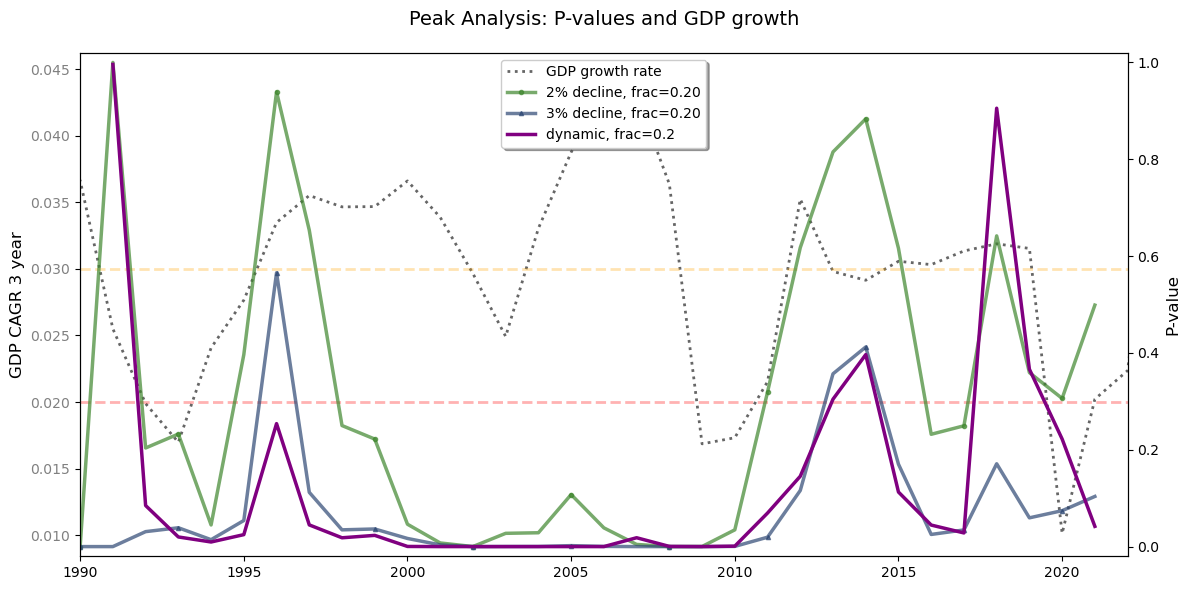

In [76]:
# Plot p-values (carbon intensity)
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

df = pd.read_csv('results/ci_fraction_tests_0203_contd.csv')
df_dy = pd.read_csv('results/ci_dynamic_growth_frac02.csv')

ci_tester = EmissionsPeakTest()
ci_tester.load_historical_data('carbon_intensity_updated.csv', region = 'WLD', year_range = range(1971,2024))
hist_data = ci_tester.historical_data

# Plot emissions on the first y-axis
ax1.set_ylabel('GDP CAGR 3 year', color='black', fontsize=12)
# ax1.plot(ci_tester.historical_data.year, ci_tester.historical_data.emissions, 
#          color='gray', linewidth=2, label='Historical carbon intensity', alpha=0.6)
ax1.plot(gdp['year'], gdp['gdp_3yr_cagr'], color = 'black', alpha = 0.6, label = 'GDP growth rate', linewidth=2, linestyle='dotted')
ax1.tick_params(axis='y', labelcolor='grey')
ref_line1 = ax1.axhline(y=0.02, color='red', linestyle='--', alpha=0.3, linewidth=2)
ref_line2 = ax1.axhline(y=0.03, color='orange', linestyle='--', alpha=0.3, linewidth=2)

# Create 2nd y axis for p-values
ax2 = ax1.twinx()
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('P-value', fontsize=12)

# Define color palettes for each null hypothesis
# Greens for null_hypothesis = 0.02 (2% annual decline)
green_palette = {
    0.150: '#1b4f0a',   # Darkest green
    0.175: '#2d6b1c',
    0.200: '#3f872e',
    0.225: '#51a340',
    0.250: '#63bf52',
    0.300: '#75db64'    # Lightest green
}

# Blues for null_hypothesis = 0.03 (3% annual decline) 
blue_palette = {
    0.150: '#0a1e3c',   # Darkest blue
    0.175: '#1c3358',
    0.200: '#2e4874',
    0.225: '#405d90',
    0.250: '#5272ac',
    0.300: '#6487c8'    # Lightest blue
}

# Use all fractions for comprehensive view, or subset for clarity
fractions_to_show = [0.2]  # Simplified view
# fractions_to_show = sorted(df['fraction'].unique())  # All fractions

# Store plotted lines for legend management
plotted_lines = []

# Plot each null hypothesis and fraction combination
for null_hyp in sorted(df['null_hypothesis'].unique()):
    # Select appropriate color palette
    colors = green_palette if null_hyp == 0.02 else blue_palette
    
    for fraction in fractions_to_show:
        # Filter data
        mask = (df['null_hypothesis'] == null_hyp) & (df['fraction'] == fraction)
        data_subset = df[mask].sort_values('year')
        
        if len(data_subset) > 0:
            # Get color for this fraction
            color = colors.get(fraction, 'gray')
            
            # Style variations
            marker = 'o' if null_hyp == 0.02 else '^'
            linewidth = 2.5 if fraction in [0.15, 0.175, 0.20] else 1.8
            alpha = 0.9 if fraction in [0.15, 0.30] else 0.7
            markersize = 5 if fraction in [0.15, 0.30] else 3
            
            # Plot the line
            label = f'{int(null_hyp*100)}% decline, frac={fraction:.2f}'
            line, = ax2.plot(data_subset['year'], 1 - data_subset['p-value'], 
                           color=color, marker=marker,
                           linewidth=linewidth, alpha=alpha,
                           markersize=markersize, 
                           markevery=3,  # Show marker every 3rd point
                           label=label)
            plotted_lines.append((line, null_hyp, fraction))

ax2.plot(df_dy['year'], 1 - df_dy['p-value'], color = 'purple', label = 'dynamic, frac=0.2', linewidth = 2.5)


# Add horizontal line at 1-p=0.66 for reference
# ax2.axhline(y=0.66, color='red', linestyle='--', alpha=0.5, label='p=0.66 threshold')

# Add reference lines
# ref_line1 = ax2.axhline(y=0.66, color='red', linestyle='--', alpha=0.6, linewidth=2)
# ref_line2 = ax2.axhline(y=0.95, color='orange', linestyle=':', alpha=0.6, linewidth=2)

# Highlight regions of significance
# ax2.axhspan(0.95, 1.0, alpha=0.08, color='green')
# ax2.axhspan(0.66, 0.95, alpha=0.04, color='yellow')

ax2.set_ylim(-0.02, 1.02)
ax2.set_xlim(1990, 2022)

# Add title and format
plt.title('Peak Analysis: P-values and GDP growth', fontsize=14, pad=20)
fig.tight_layout()

# Add legends - combining both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', frameon=True, 
           fancybox=True, shadow=True)

In [84]:

# ci_tester = EmissionsPeakTest()
# ci_tester.load_historical_data('fossil_intensity.csv', year_range = range(1971,2024))

# hist_data = ci_tester.historical_data
# p_list = []
# years_to_check = np.arange(1991, 2022, 1)
# for year in years_to_check:
#     years_to_test = [year, year+1, year+2]
    
#     em_0 = hist_data.loc[hist_data.year==year,'emissions'].squeeze()
#     em_1 = hist_data.loc[hist_data.year==year+1,'emissions'].squeeze()
#     em_2 = hist_data.loc[hist_data.year==year+2,'emissions'].squeeze()

#     gdp_growth_rate = gdp.loc[gdp['year']==year+2, 'gdp_3yr_cagr']

#     # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
#     with HiddenPrints():
#         ci_tester.historical_data = hist_data.query(f'year <= {year}').copy()
#         ci_tester.characterize_noise(method='loess', fraction = 0.3, noise_type = 't-dist') # 
#         ci_tester.create_noise_generator()
#         ci_tester.set_test_data([
#                 (year, em_0),
#                 (year+1, em_1), 
#                 (year+2, em_2),
#             ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap', null_hypothesis=em_0*float(-1*gdp_growth_rate))
#         p_list.append(ci_tester.bootstrap_results['p_value_one_tail'])
    
# pdf_ci_dynamic_frac3 = pd.DataFrame({
#     'year': years_to_check,
#     'p-value': p_list
# })

Loaded historical data: 1971-2023
Data points: 53


Loaded historical data: 1971-2023
Data points: 53


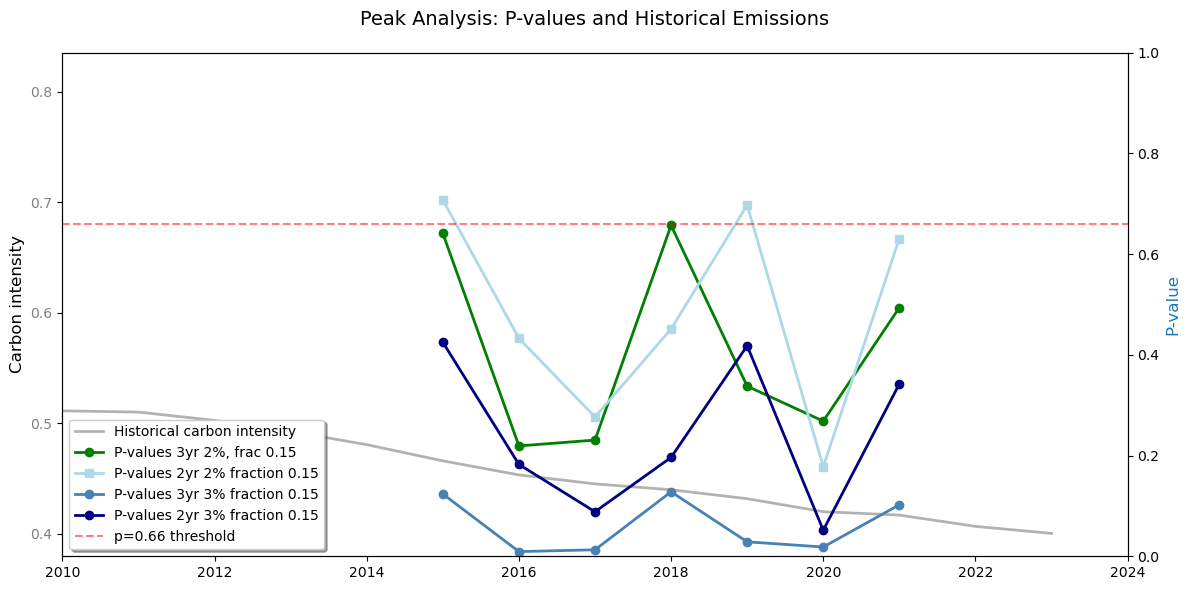

In [125]:
# Plot p-values (carbon intensity)
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

ci_tester = EmissionsPeakTest()
ci_tester.load_historical_data('carbon_intensity_updated.csv', region = 'WLD', year_range = range(1971,2024))

hist_data = ci_tester.historical_data

# Plot emissions on the first y-axis
ax1.set_ylabel('Carbon intensity', color='black', fontsize=12)
ax1.plot(ci_tester.historical_data.year, ci_tester.historical_data.emissions, 
         color='gray', linewidth=2, label='Historical carbon intensity', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='grey')

# Create 2nd y axis for p-values
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('P-value', color=color, fontsize=12)

# ax2.plot(pdf_ci['year'], 1-pdf_ci['p-value'], color=color, marker='o', 
#          linewidth=2, label='P-value, historical years, t-dist, 3%', markersize=6)
# ax2.tick_params(axis='y', labelcolor='black')
# ax2.grid(True, alpha=0.3)

ax2.plot(ci_3year_frac15_null02['year'], 1-ci_3year_frac15_null02['p-value'], color='green', marker='o', 
         linewidth=2, label='P-values 3yr 2%, frac 0.15', markersize=6)
# ax2.tick_params(axis='y', labelcolor=color)

ax2.plot(ci_2year_frac15_null02['year'], 1-ci_2year_frac15_null02['p-value'], color='lightblue', marker='s', 
         linewidth=2, label='P-values 2yr 2% fraction 0.15', markersize=6)


ax2.plot(ci_3year_frac15_null03['year'], 1-ci_3year_frac15_null03['p-value'], color='steelblue', marker='o', 
         linewidth=2, label='P-values 3yr 3% fraction 0.15', markersize=6)

ax2.plot(ci_2year_frac15_null03['year'], 1-ci_2year_frac15_null03['p-value'], color='navy', marker='o', 
         linewidth=2, label='P-values 2yr 3% fraction 0.15', markersize=6)

# Add horizontal line at 1-p=0.66 for reference
ax2.axhline(y=0.66, color='red', linestyle='--', alpha=0.5, label='p=0.66 threshold')
# Set y-limits for p-values with some padding
max_p = max(ci_2year_frac15_null02['emissions_tested'])
ax2.set_ylim(0, 1)
ax2.set_xlim(2010, 2024)
# ax3 = ax2.twinx()
# color = 'tab:green'
# ax3.set_xlabel('Year', fontsize=12)
# ax3.set_ylabel('GDP', color='green', fontsize=12)

# ax3.plot(gdp['year'], gdp['emissions'], color='orange', marker='o', alpha=0.8,
#          linewidth=2, label='GDP', markersize=3)


# Add title and format
plt.title('Peak Analysis: P-values and Historical Emissions', fontsize=14, pad=20)
fig.tight_layout()

# Add legends - combining both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', frameon=True, 
           fancybox=True, shadow=True)

plt.savefig("../figures/pvalue_analysis_ci.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# is CI falling enough to on average overcome GDP growth? Null hypothesis = average GDP growth (or 25th or 75th percentiles)

In [80]:
results = pd.read_csv('results/ci_fraction_tests_0203_contd.csv')
results

Unnamed: 0  year region  p-value  num_years_forward noise_type  fraction  \
0             0  1975    WLD   1.0000                  3     t-dist      0.15   
1             1  1976    WLD   1.0000                  3     t-dist      0.15   
2             2  1977    WLD   1.0000                  3     t-dist      0.15   
3             3  1978    WLD   1.0000                  3     t-dist      0.15   
4             4  1979    WLD   0.0000                  3     t-dist      0.15   
..          ...   ...    ...      ...                ...        ...       ...   
559         559  2017    WLD   0.9494                  3     t-dist      0.30   
560         560  2018    WLD   0.7997                  3     t-dist      0.30   
561         561  2019    WLD   0.8506                  3     t-dist      0.30   
562         562  2020    WLD   0.9257                  3     t-dist      0.30   
563         563  2021    WLD   0.8454                  3     t-dist      0.30   

     null_hypothesis  test_year  
0               0.02       1975  
1               0.02       1976  
2               0.02       1977  
3               0.02       1978  
4               0.02       1979  
..               ...        ...  
559             0.03       2017  
560             0.03       2018  
561             0.03       2019  
562             0.03       2020  
563             0.03       2021  

[564 rows x 9 columns]

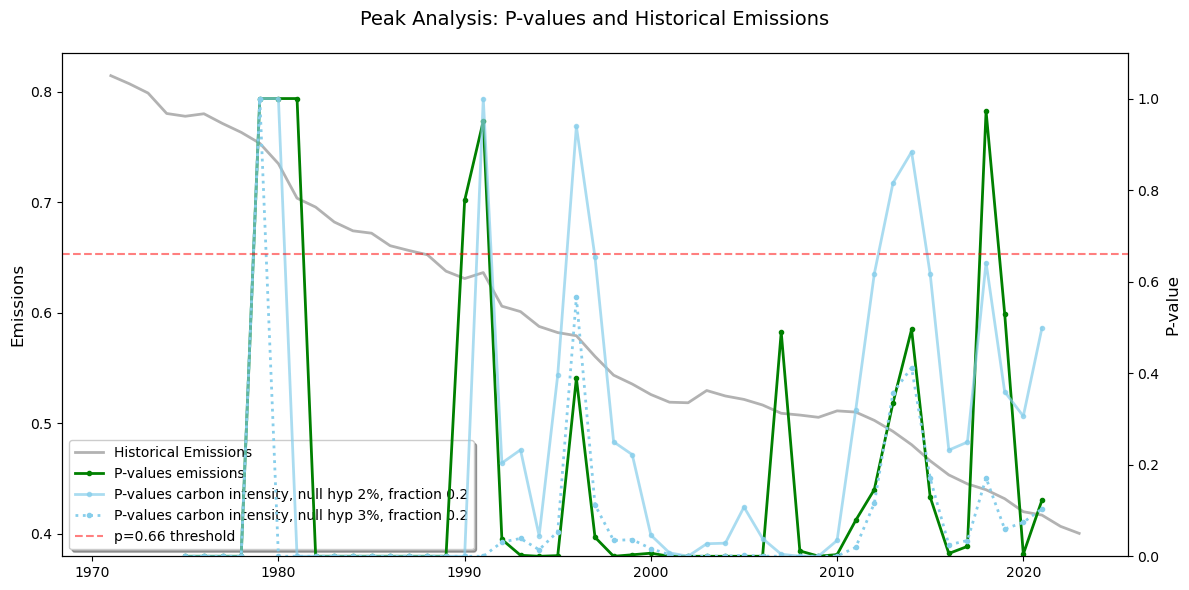

In [96]:
# Plot both emissions and CI

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot emissions on the first y-axis

ax1.set_ylabel('Emissions', color='black', fontsize=12)
ax1.plot(hist_data.year, hist_data.emissions, 
         color='gray', linewidth=2, label='Historical Emissions', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='black')

# Create 2nd y axis for p-values
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('P-value', color='black', fontsize=12)

#p values for emissions
pdf = pdf_3year.copy()

#p values for CI
results = pd.read_csv('results/ci_fraction_tests_0203_contd.csv')
pdf2 = results.loc[(results['fraction']==0.2) & (results['null_hypothesis']== 0.02)]
pdf3 = results.loc[(results['fraction']==0.2) & (results['null_hypothesis']== 0.03)]

ax2.plot(pdf['year'], 1-pdf['p-value'], color='green', marker='o', 
         linewidth=2, label='P-values emissions', markersize=3)



ax2.plot(pdf2['year'], 1-pdf2['p-value'], color='skyblue', marker='o', 
         linewidth=2, label='P-values carbon intensity, null hyp 2%, fraction 0.2', markersize=3, alpha = 0.7)

ax2.plot(pdf3['year'], 1-pdf3['p-value'], color='skyblue', marker='o', 
         linewidth=2, label='P-values carbon intensity, null hyp 3%, fraction 0.2', markersize=3, linestyle = 'dotted')


# Add horizontal line at 1-p=0.66 for reference
ax2.axhline(y=0.66, color='red', linestyle='--', alpha=0.5, label='p=0.66 threshold')
# Set y-limits for p-values with some padding

ax2.set_ylim(0, 1.1)



# Add title and format
plt.title('Peak Analysis: P-values and Historical Emissions', fontsize=14, pad=20)
fig.tight_layout()

# Add legends - combining both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', frameon=True, 
           fancybox=True, shadow=True)
plt.savefig("../figures/pvalue_analysis_ci.png", dpi=300, bbox_inches='tight')
plt.show()

# Test fractions for LOESS

## Emissions fractions

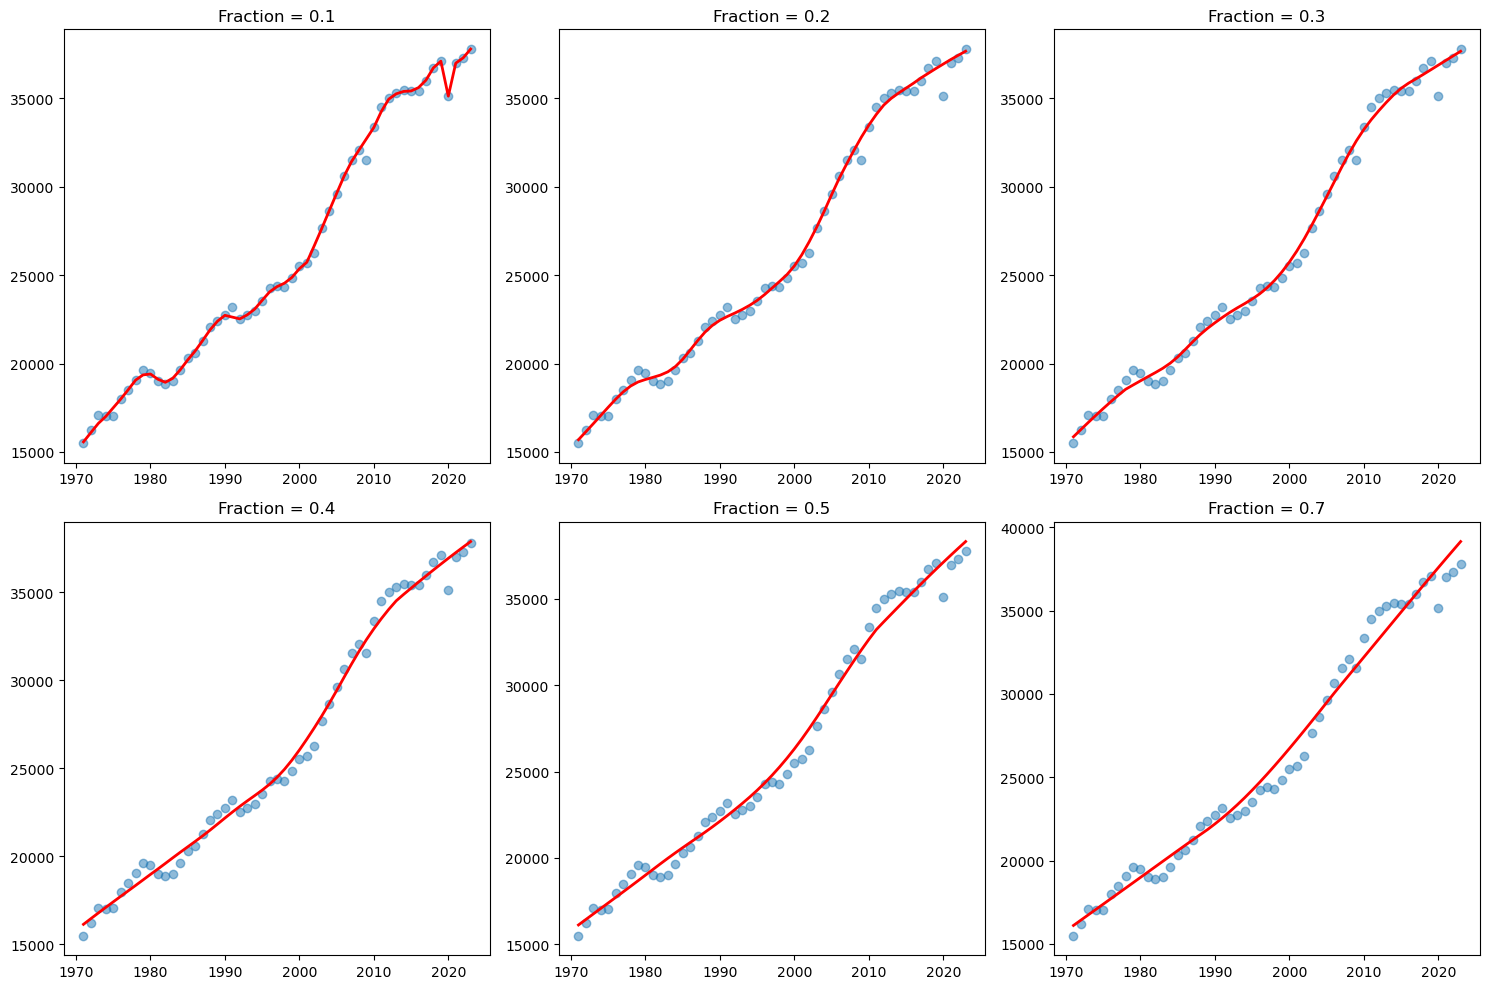

In [174]:

emissions = peak_tester.historical_data['emissions']
years = peak_tester.historical_data['year']

# Test multiple fractions
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, frac in enumerate(fractions):
    lowess = sm.nonparametric.lowess(emissions, years, frac=frac)
    axes[i].scatter(years, emissions, alpha=0.5)
    axes[i].plot(lowess[:, 0], lowess[:, 1], 'r-', linewidth=2)
    axes[i].set_title(f'Fraction = {frac}')


# plt.xlim([1990, 2023])
plt.tight_layout()
plt.show()

In [162]:

peak_tester2 = EmissionsPeakTest()
peak_tester2.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,2024))
hist_data = peak_tester2.historical_data

years_to_check = np.arange(1975, 2022, 1)
all_results = []

for frac in [0.1, 0.15, 0.2, 0.25, 0.3]:

    for year in years_to_check:
        years_to_test = [year, year+1, year+2]
        
        em_0 = hist_data.loc[hist_data.year==year,'emissions'].squeeze()
        em_1 = hist_data.loc[hist_data.year==year+1,'emissions'].squeeze()
        em_2 = hist_data.loc[hist_data.year==year+2,'emissions'].squeeze()
    
        # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
        with HiddenPrints():
            peak_tester2.historical_data = hist_data.query(f'year <= {year}').copy()
            peak_tester2.characterize_noise(method='loess', frac = frac, noise_type = 't-dist') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
            peak_tester2.create_noise_generator()
            peak_tester2.set_test_data([
                    (year, em_0),
                    (year+1, em_1), 
                    # (year+2, em_2),
                ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
            all_results.append({
                'year': year,
                'frac': frac,
                'p-value': peak_tester2.bootstrap_results['p_value_one_tail']
            })
        
df_frac = pd.DataFrame(all_results)


Loaded historical data: 1971-2023
Data points: 53


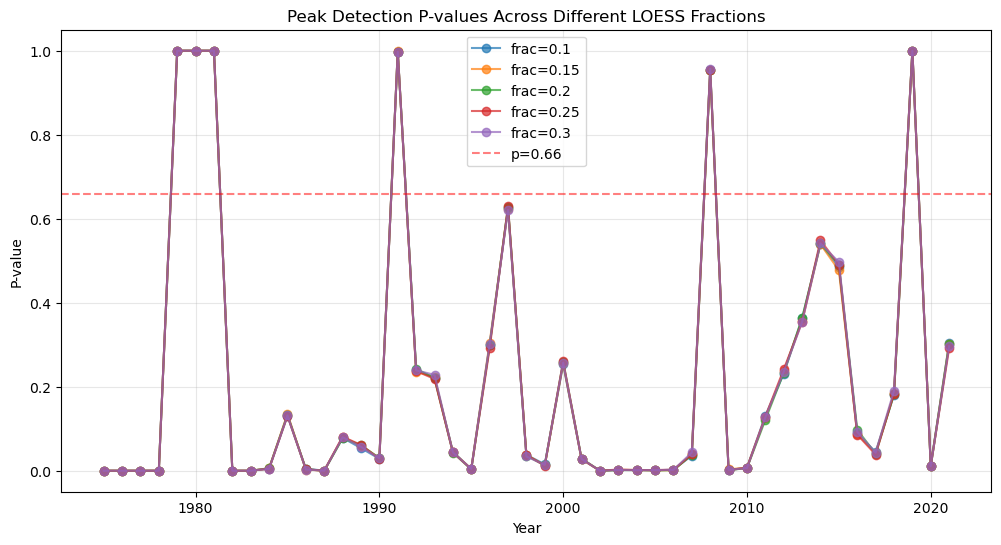

In [166]:
fig, ax = plt.subplots(figsize=(12, 6))


for frac in [0.1, 0.15, 0.2, 0.25, 0.3]:
    df = df_frac[df_frac['frac'] == frac]
    ax.plot(df['year'], 1-df['p-value'], 
            marker='o', label=f'frac={frac}', alpha=0.7)

ax.axhline(y=0.66, color='red', linestyle='--', alpha=0.5, label='p=0.66')
ax.set_xlabel('Year')
ax.set_ylabel('P-value')
ax.set_title('Peak Detection P-values Across Different LOESS Fractions')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## Carbon intensity fractions

IndexError: index 6 is out of bounds for axis 0 with size 6

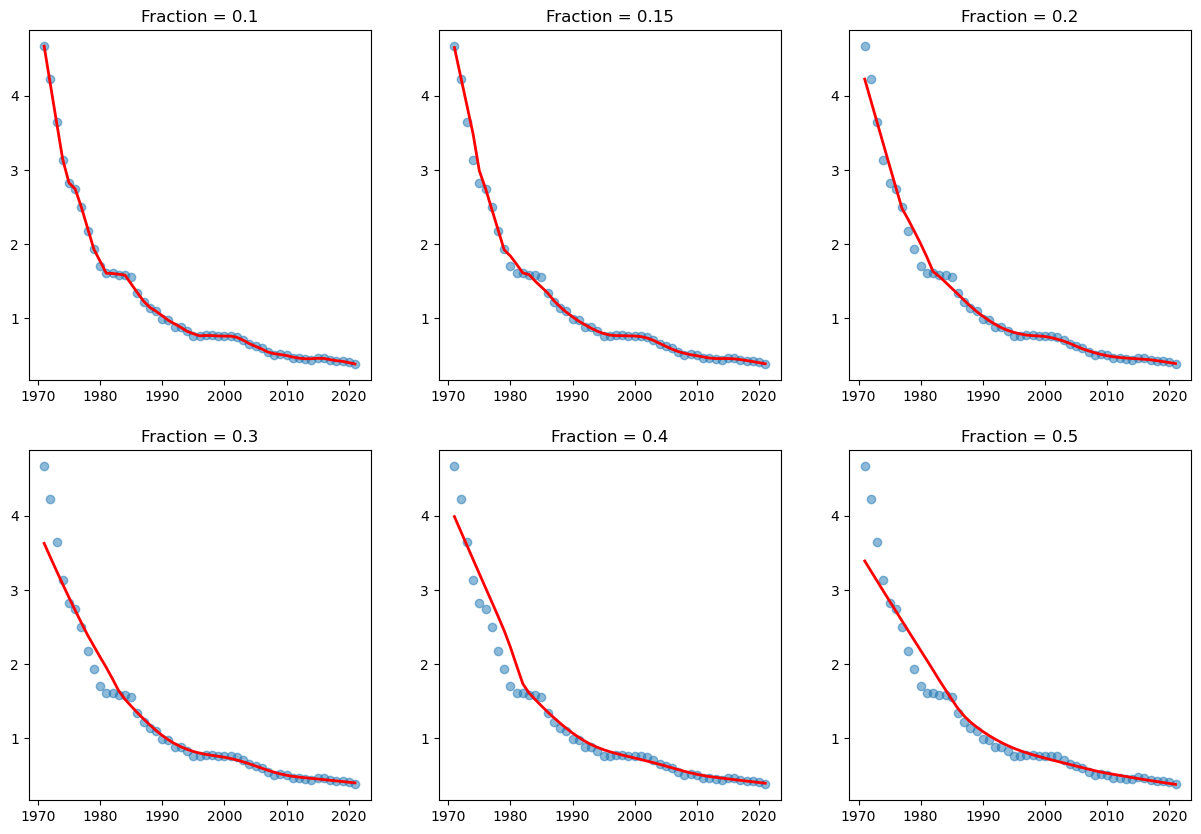

In [175]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

ci = ci_tester.historical_data['emissions']
years = ci_tester.historical_data['year']

# Test multiple fractions
fractions = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, frac in enumerate(fractions):
    lowess = sm.nonparametric.lowess(ci, years, frac=frac)
    axes[i].scatter(years, ci, alpha=0.5)
    axes[i].plot(lowess[:, 0], lowess[:, 1], 'r-', linewidth=2)
    axes[i].set_title(f'Fraction = {frac}')


plt.xlim([1990, 2023])
plt.tight_layout()
plt.show()


In [126]:
from sklearn.model_selection import KFold, LeaveOneOut


def loess_cv_detailed(fractions, x, y, cv_method='timeseries', k=5, random_state=42):
    """
    Comprehensive cross-validation for LOESS fraction selection
    
    Parameters:
    - fractions: array of fractions to test
    - x, y: your data
    - cv_method: 'kfold', 'loo' (leave-one-out), or 'timeseries'
    - k: number of folds for k-fold CV
    """
    
    results = {
        'fractions': fractions,
        'mean_mse': [],
        'std_mse': [],
        'mean_mae': [],
        'std_mae': []
    }
    
    for frac in fractions:
        mse_scores = []
        mae_scores = []
        
        if cv_method == 'kfold':
            # K-Fold: randomly splits data into k groups
            kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
            splits = kf.split(x)
            
        elif cv_method == 'loo':
            # Leave-One-Out: each point is test set once
            loo = LeaveOneOut()
            splits = loo.split(x)
            
        elif cv_method == 'timeseries':
            # Time series split: respects temporal order
            from sklearn.model_selection import TimeSeriesSplit
            tscv = TimeSeriesSplit(n_splits=k)
            splits = tscv.split(x)
        
        for train_idx, test_idx in splits:
            # Split data
            x_train, x_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            try:
                # Fit LOESS on training data
                lowess = sm.nonparametric.lowess(y_train, x_train, frac=frac)
                
                # Predict on test data using interpolation
                # Sort lowess results by x values for proper interpolation
                sorted_idx = np.argsort(lowess[:, 0])
                x_smooth = lowess[sorted_idx, 0]
                y_smooth = lowess[sorted_idx, 1]
                
                # Interpolate predictions for test points
                y_pred = np.interp(x_test, x_smooth, y_smooth)
                
                # Calculate errors
                mse = np.mean((y_test - y_pred) ** 2)
                mae = np.mean(np.abs(y_test - y_pred))
                
                mse_scores.append(mse)
                mae_scores.append(mae)
                
            except:
                # Handle cases where LOESS fails (too few points)
                continue
        
        # Store results
        results['mean_mse'].append(np.mean(mse_scores))
        results['std_mse'].append(np.std(mse_scores))
        results['mean_mae'].append(np.mean(mae_scores))
        results['std_mae'].append(np.std(mae_scores))
    
    return pd.DataFrame(results)

Optimal fraction for peak detection: 0.080


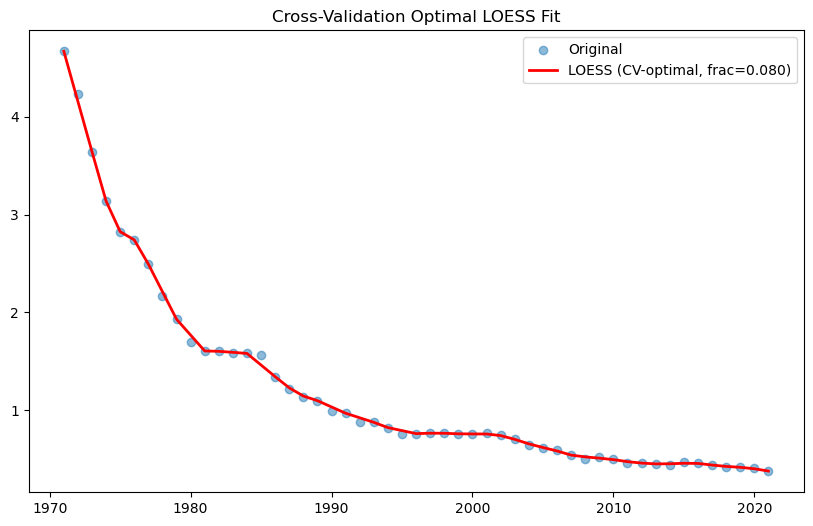

In [130]:
# Recommended approach for emissions peak detection
fractions = np.arange(0.05, 0.4, 0.01)  # Focus on smaller fractions
cv_results = loess_cv_detailed(fractions, years.values, ci.values, 
                                cv_method='loo')

optimal_frac = cv_results.loc[cv_results['mean_mse'].idxmin(), 'fractions']
print(f"Optimal fraction for peak detection: {optimal_frac:.3f}")

# Verify it preserves the peak
lowess_optimal = sm.nonparametric.lowess(ci, years, frac=optimal_frac)
plt.figure(figsize=(10, 6))
plt.scatter(years, ci, alpha=0.5, label='Original')
plt.plot(lowess_optimal[:, 0], lowess_optimal[:, 1], 'r-', 
         linewidth=2, label=f'LOESS (CV-optimal, frac={optimal_frac:.3f})')
plt.legend()
plt.title('Cross-Validation Optimal LOESS Fit')
plt.show()

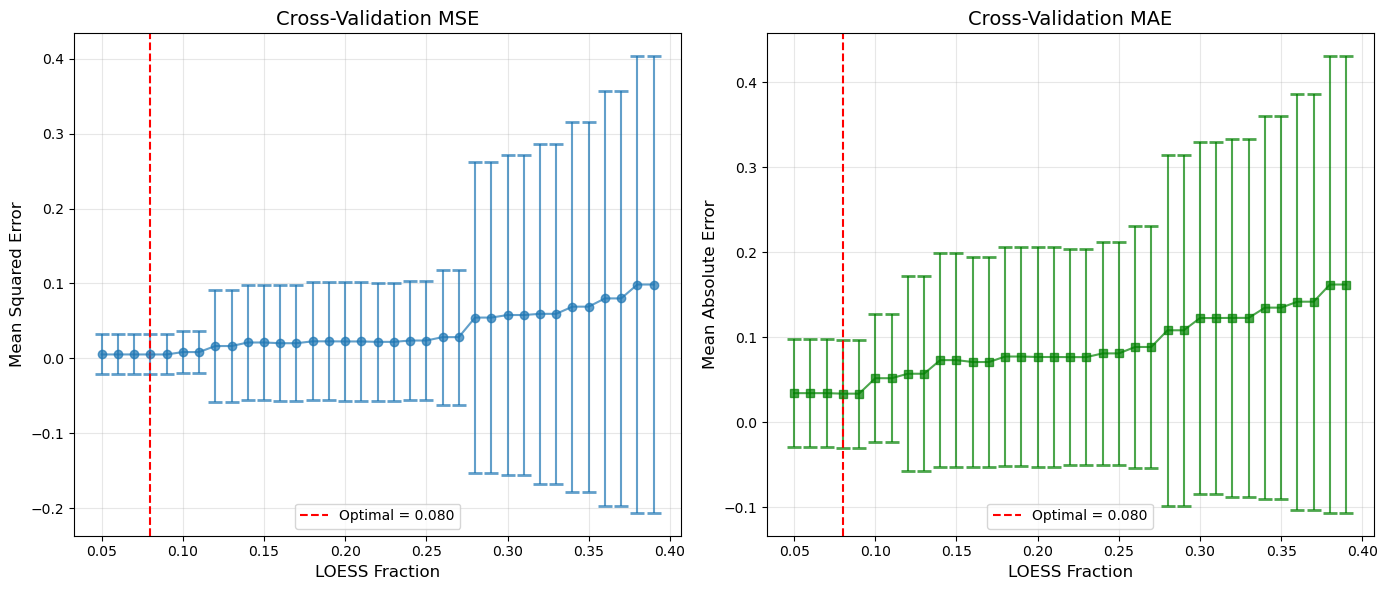

In [137]:
def plot_cv_results(cv_results):
    """Visualize cross-validation results with confidence intervals"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot MSE with error bars
    ax1 = axes[0]
    ax1.errorbar(cv_results['fractions'], 
                 cv_results['mean_mse'],
                 yerr=cv_results['std_mse'],
                 marker='o', capsize=5, capthick=2, alpha=0.7)
    
    optimal_idx = cv_results['mean_mse'].idxmin()
    ax1.axvline(cv_results.loc[optimal_idx, 'fractions'], 
                color='red', linestyle='--', 
                label=f'Optimal = {cv_results.loc[optimal_idx, "fractions"]:.3f}')
    
    ax1.set_xlabel('LOESS Fraction', fontsize=12)
    ax1.set_ylabel('Mean Squared Error', fontsize=12)
    ax1.set_title('Cross-Validation MSE', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot MAE with error bars
    ax2 = axes[1]
    ax2.errorbar(cv_results['fractions'], 
                 cv_results['mean_mae'],
                 yerr=cv_results['std_mae'],
                 marker='s', capsize=5, capthick=2, alpha=0.7, color='green')
    
    optimal_mae_idx = cv_results['mean_mae'].idxmin()
    ax2.axvline(cv_results.loc[optimal_mae_idx, 'fractions'], 
                color='red', linestyle='--',
                label=f'Optimal = {cv_results.loc[optimal_mae_idx, "fractions"]:.3f}')
    
    ax2.set_xlabel('LOESS Fraction', fontsize=12)
    ax2.set_ylabel('Mean Absolute Error', fontsize=12)
    ax2.set_title('Cross-Validation MAE', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize the results
plot_cv_results(cv_results)

In [121]:
def time_series_cv(fractions, x, y, min_train_size=10, horizon=3):
    """
    Special CV for time series that respects temporal order
    
    Parameters:
    - min_train_size: minimum training set size
    - horizon: how many points ahead to predict
    """
    
    n = len(x)
    results = []
    
    for frac in fractions:
        errors = []
        
        # Rolling window approach
        for split_point in range(min_train_size, n - horizon):
            # Training: all data up to split_point
            x_train = x[:split_point]
            y_train = y[:split_point]
            
            # Test: next 'horizon' points
            x_test = x[split_point:split_point + horizon]
            y_test = y[split_point:split_point + horizon]
            
            # Fit and predict
            lowess = sm.nonparametric.lowess(y_train, x_train, frac=frac)
            y_pred = np.interp(x_test, lowess[:, 0], lowess[:, 1])
            
            # Calculate error
            mse = np.mean((y_test - y_pred) ** 2)
            errors.append(mse)
        
        results.append({
            'fraction': frac,
            'mean_error': np.mean(errors),
            'std_error': np.std(errors)
        })
    
    return pd.DataFrame(results)

# For emissions time series
ts_cv_results = time_series_cv(fractions, years.values, ci.values, 
                                min_train_size=15, horizon=2)

optimal_ts_frac = ts_cv_results.loc[ts_cv_results['mean_error'].idxmin(), 'fraction']
print(f"Optimal fraction for time series: {optimal_ts_frac:.3f}")

Optimal fraction for time series: 0.240


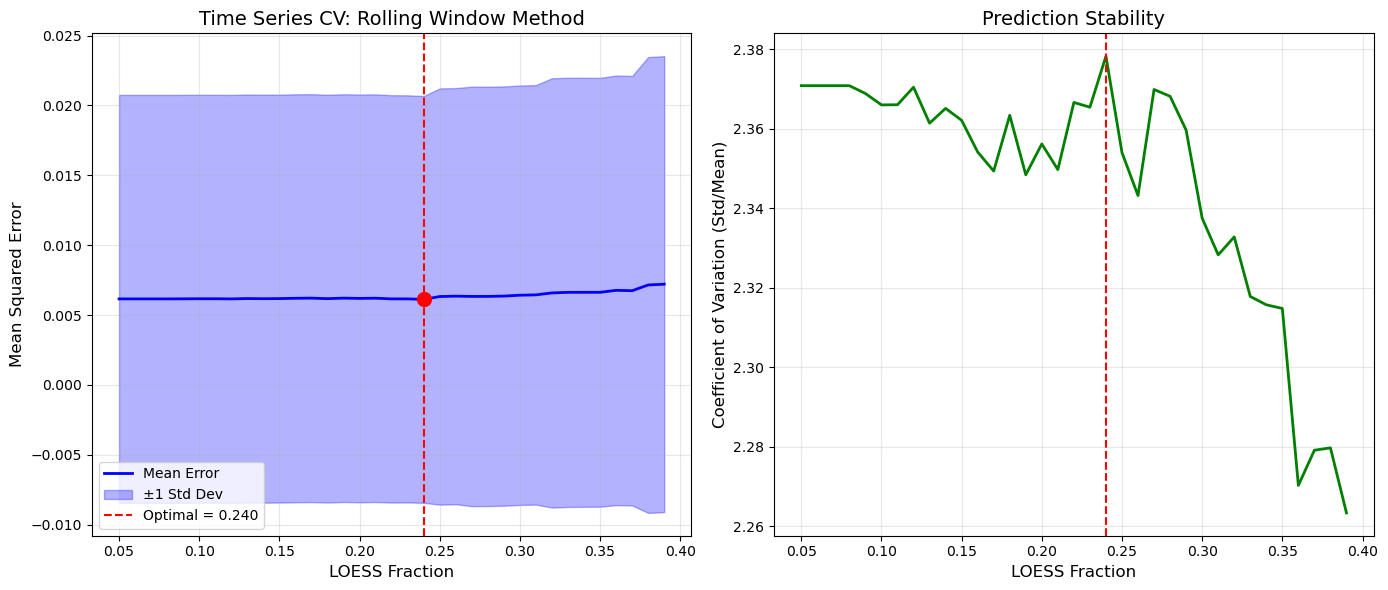

Optimal fraction: 0.240
Error at optimal: 0.0061 ± 0.0146


In [138]:
def plot_ts_cv_results(ts_cv_results):
    """Plot time series cross-validation results"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Mean error with standard deviation bands
    ax1 = axes[0]
    ax1.plot(ts_cv_results['fraction'], ts_cv_results['mean_error'], 
             'b-', linewidth=2, label='Mean Error')
    
    # Add confidence bands
    ax1.fill_between(ts_cv_results['fraction'],
                     ts_cv_results['mean_error'] - ts_cv_results['std_error'],
                     ts_cv_results['mean_error'] + ts_cv_results['std_error'],
                     alpha=0.3, color='blue', label='±1 Std Dev')
    
    # Mark optimal
    optimal_idx = ts_cv_results['mean_error'].idxmin()
    optimal_frac = ts_cv_results.loc[optimal_idx, 'fraction']
    optimal_error = ts_cv_results.loc[optimal_idx, 'mean_error']
    
    ax1.axvline(optimal_frac, color='red', linestyle='--', 
                label=f'Optimal = {optimal_frac:.3f}')
    ax1.scatter(optimal_frac, optimal_error, color='red', s=100, zorder=5)
    
    ax1.set_xlabel('LOESS Fraction', fontsize=12)
    ax1.set_ylabel('Mean Squared Error', fontsize=12)
    ax1.set_title('Time Series CV: Rolling Window Method', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Coefficient of variation (relative variability)
    ax2 = axes[1]
    cv_coefficient = ts_cv_results['std_error'] / ts_cv_results['mean_error']
    ax2.plot(ts_cv_results['fraction'], cv_coefficient, 
             'g-', linewidth=2)
    ax2.axvline(optimal_frac, color='red', linestyle='--')
    
    ax2.set_xlabel('LOESS Fraction', fontsize=12)
    ax2.set_ylabel('Coefficient of Variation (Std/Mean)', fontsize=12)
    ax2.set_title('Prediction Stability', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Optimal fraction: {optimal_frac:.3f}")
    print(f"Error at optimal: {optimal_error:.4f} ± {ts_cv_results.loc[optimal_idx, 'std_error']:.4f}")

# Plot your results
plot_ts_cv_results(ts_cv_results)

Optimal fraction for time series: 0.200


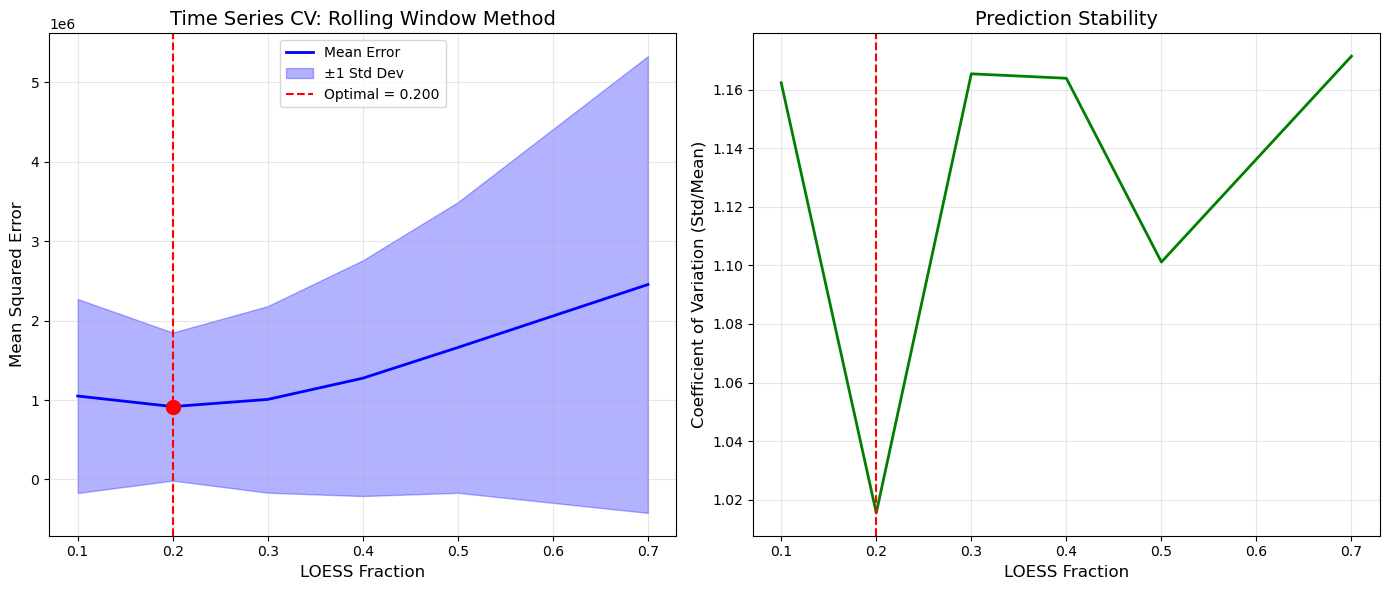

Optimal fraction: 0.200
Error at optimal: 917368.8491 ± 931535.3913


In [157]:
ts_cv_results_emissions = time_series_cv(fractions, years.values, emissions.values, 
                                min_train_size=15, horizon=2)

optimal_ts_frac_emissions = ts_cv_results_emissions.loc[ts_cv_results_emissions['mean_error'].idxmin(), 'fraction']
print(f"Optimal fraction for time series: {optimal_ts_frac_emissions:.3f}")
plot_ts_cv_results(ts_cv_results_emissions)

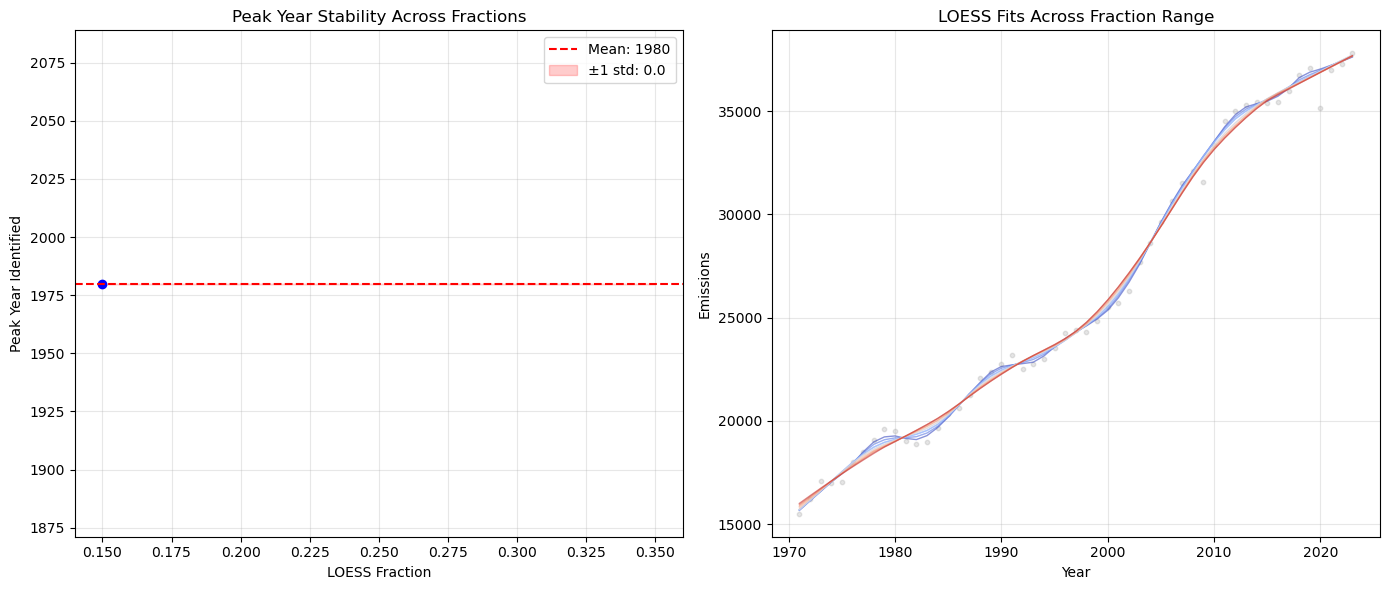

Peak Year Statistics (across fractions 0.15-0.35):
  Mean peak year: 1980.0
  Std deviation: 0.0 years
  Range: 1980 - 1980
  → CONSISTENT: Peak identification is stable across fractions


In [142]:
from scipy.signal import find_peaks
def peak_consistency_test(x, y, fraction_range=(0.15, 0.35)):
    """
    Test if peak identification is consistent across different fractions
    """
    fractions = np.linspace(fraction_range[0], fraction_range[1], 20)
    peak_years = []
    peak_values = []
    
    for frac in fractions:
        lowess = sm.nonparametric.lowess(y, x, frac=frac)
        peaks, _ = find_peaks(lowess[:, 1], prominence=0.01)
        
        if len(peaks) > 0:
            peak_years.append(lowess[peaks[0], 0])
            peak_values.append(lowess[peaks[0], 1])
        else:
            peak_years.append(np.nan)
            peak_values.append(np.nan)
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Peak year vs fraction
    ax1 = axes[0]
    ax1.plot(fractions, peak_years, 'b-', linewidth=2, marker='o')
    ax1.set_xlabel('LOESS Fraction')
    ax1.set_ylabel('Peak Year Identified')
    ax1.set_title('Peak Year Stability Across Fractions')
    ax1.grid(True, alpha=0.3)
    
    # Add bands for consistent regions
    if not all(np.isnan(peak_years)):
        peak_years_clean = [y for y in peak_years if not np.isnan(y)]
        mean_year = np.mean(peak_years_clean)
        std_year = np.std(peak_years_clean)
        ax1.axhline(mean_year, color='red', linestyle='--', 
                   label=f'Mean: {mean_year:.0f}')
        ax1.fill_between(fractions, mean_year - std_year, mean_year + std_year,
                         alpha=0.2, color='red', label=f'±1 std: {std_year:.1f}')
        ax1.legend()
    
    # Plot 2: Show all fits
    ax2 = axes[1]
    ax2.scatter(x, y, alpha=0.2, s=10, color='gray', label='Data')
    
    # Color gradient for fractions
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(fractions)))
    
    for i, frac in enumerate(fractions[::2]):  # Plot every other for clarity
        lowess = sm.nonparametric.lowess(y, x, frac=frac)
        ax2.plot(lowess[:, 0], lowess[:, 1], color=colors[i*2], 
                alpha=0.6, linewidth=1)
    
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Emissions')
    ax2.set_title('LOESS Fits Across Fraction Range')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    peak_years_clean = [y for y in peak_years if not np.isnan(y)]
    if peak_years_clean:
        print(f"Peak Year Statistics (across fractions {fraction_range[0]:.2f}-{fraction_range[1]:.2f}):")
        print(f"  Mean peak year: {np.mean(peak_years_clean):.1f}")
        print(f"  Std deviation: {np.std(peak_years_clean):.1f} years")
        print(f"  Range: {min(peak_years_clean):.0f} - {max(peak_years_clean):.0f}")
        
        if np.std(peak_years_clean) < 2:
            print("  → CONSISTENT: Peak identification is stable across fractions")
        else:
            print("  → INCONSISTENT: Peak year varies significantly with fraction")

# Test consistency
emissions = peak_tester.historical_data['emissions']
years = peak_tester.historical_data['year']
peak_consistency_test(years.values, emissions.values, fraction_range=(0.15, 0.35))